# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> __1)__  **Kullback-Leibler (KL) Divergence:**

  KL divergence measures how different one probability distribution is from another one. It's not symmetric, meaning the KL divergence of $p_D$ from $p_\theta$ is not the same as the KL divergence of $p_\theta$ from $p_D$. It is defined as:

  $$D_{KL}(p_D | p_\theta)= \sum_x p_D(x) \log \frac{p_D(x)}{p_\theta(x)}  $$

  __2)__ **Jensen-Shannon (JS) Divergence:**

JS divergence is like KL divergence but symmetric. It's the average of the KL divergence between $p_D$ and $p_\theta$, and the KL divergence between $p_\theta$ and $p_D$. It is defined as:

$$D_{JS}(p_D | p_\theta) = \frac 1 2 D_{KL}(p_D | M) + \frac 1 2 D_{KL}(p_\theta | M)  $$

where $M = \frac{1}{2}(p_D + p_\theta)$.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

>When using these metrics to improve a model, remember some important points:

- Non-differentiability: Some metrics may not allow for easy calculation of changes needed to improve the model. In these cases, other methods can be used.

- Mode collapse: When using some metrics, the model may only generate data that covers a small part of the real distribution. This can happen with KL divergence.

- Computational complexity: Some metrics, like Wasserstein distance, may need more computation, making training and optimization slower.

- Sensitivity to noise: Some metrics may be more sensitive to noise or small differences between distributions, affecting optimization and the quality of the generated data.

- Asymmetry: Asymmetric metrics like KL divergence may lead to different improvements depending on the order of the input distributions. This could affect the model's performance in capturing the real data distribution.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

The choice of N, the size of input noise $\epsilon$, has some effects on GAN:

- Expressiveness: Bigger N helps the GAN model to make more complex and different examples in the data. If N is very small, the model may have problem to make samples that cover all the real data distribution.

- Training hard: When N grows, the difficulty of training also grows. This can make training time longer and issues in learning, as the generator and discriminator networks need to learn more difficult connections between input noise and made samples.

- Overfitting: Bigger N can make overfitting risk higher, as the model can become too flexible and start to remember training data instead of learning the real data distribution. Techniques to control this risk can be used.

- Need more computer power: The choice of N will also change how much computer memory and processing power is needed for training and making samples. Bigger values of N may need more resources for the generator network and training process.

In summary, the choice of N is important, as it affects how good, training difficulty, overfitting risk, and computer needs of the GAN. A balance must be made between these factors to get the wanted performance and sample quality.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions.
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

One problem when using JSD as training objective for generator is that JSD may not be good at finding differences between two distributions, especially when they not overlap. In this case, the JSD becomes constant and the generator may not improve. This makes training slow or not work, and generator might have trouble to make different samples that cover all real data distribution.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

The generator loss $\mathcal{L}G = \mathbb{E}{p_\theta} \log(1-D(x))$ only provides feedback based on samples generated by the generator itself, without considering the real data distribution. This can lead to a phenomenon known as "mode collapse," where the generator focuses on generating samples that cover only a small portion of the real data distribution, neglecting other modes of the distribution. As a result, the generated samples might lack diversity and fail to capture the full range of the real data distribution.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [ ]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

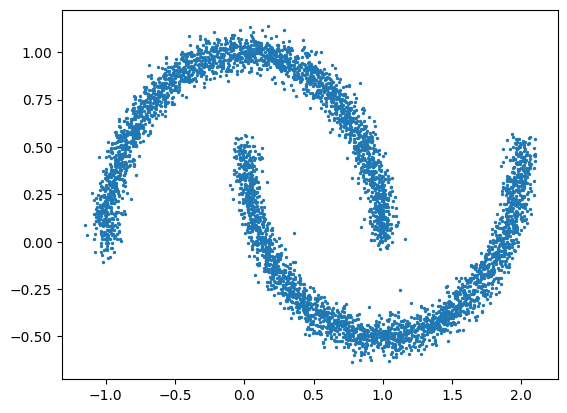

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)

    def __call__(self, z):
        return self.fc1(z)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)

    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.509e+00, generator: 9.268e-01


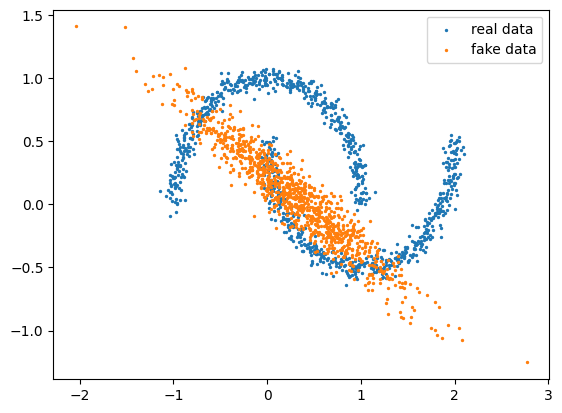

step 1000: discriminator: 1.391e+00, generator: 6.958e-01


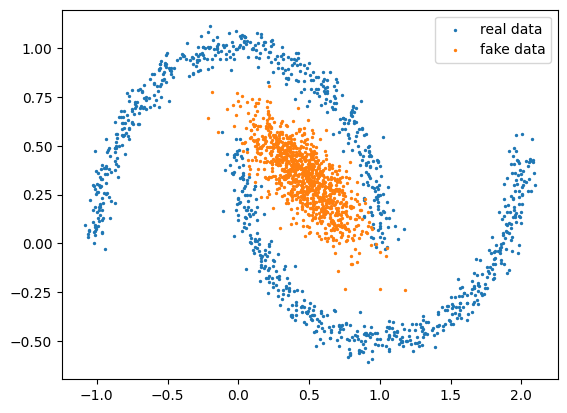

step 2000: discriminator: 1.386e+00, generator: 6.932e-01


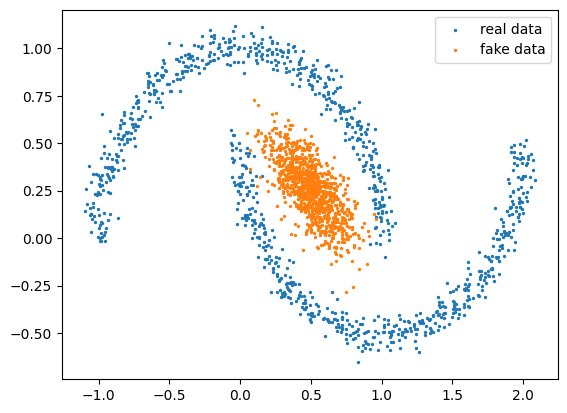

step 3000: discriminator: 1.386e+00, generator: 6.931e-01


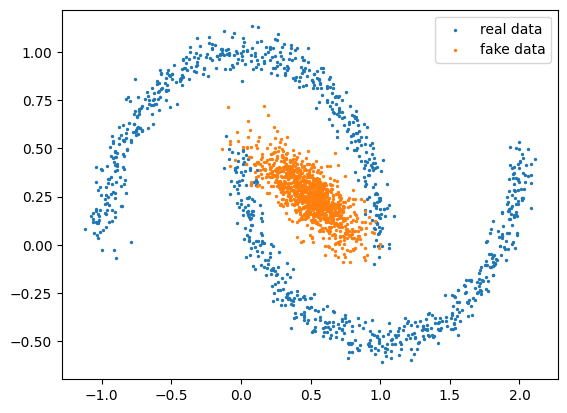

step 4000: discriminator: 1.386e+00, generator: 6.931e-01


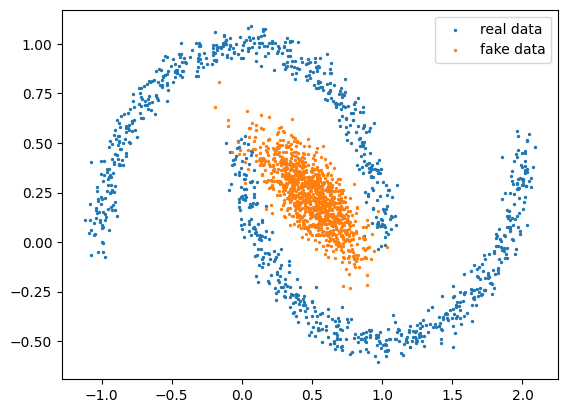

step 5000: discriminator: 1.386e+00, generator: 6.929e-01


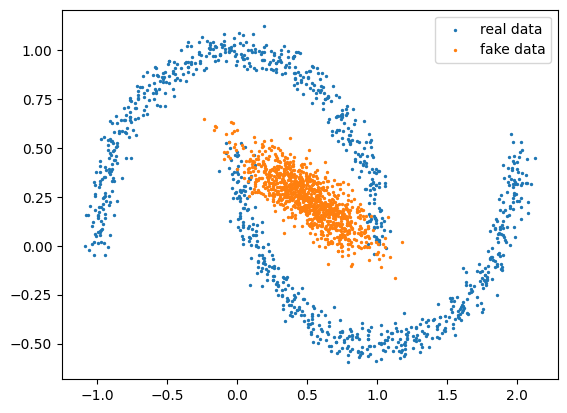

step 6000: discriminator: 1.386e+00, generator: 6.932e-01


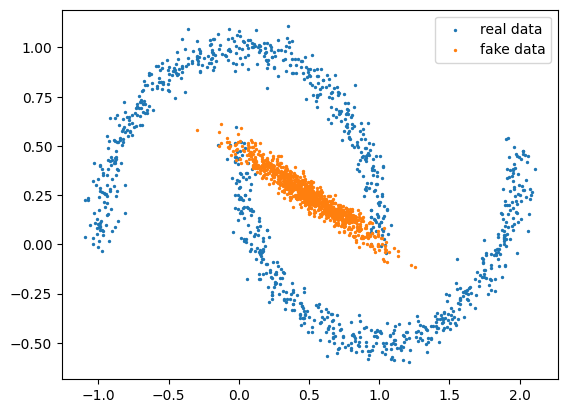

step 7000: discriminator: 1.386e+00, generator: 6.929e-01


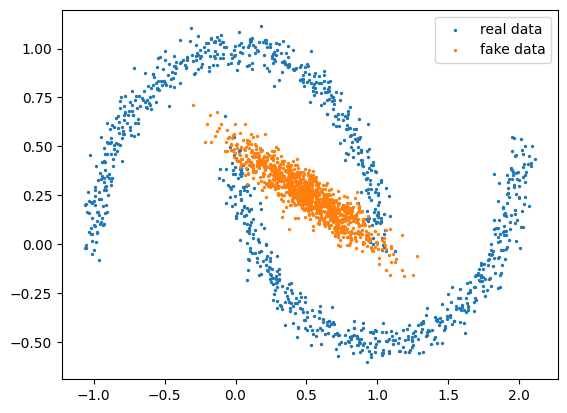

step 8000: discriminator: 1.386e+00, generator: 6.934e-01


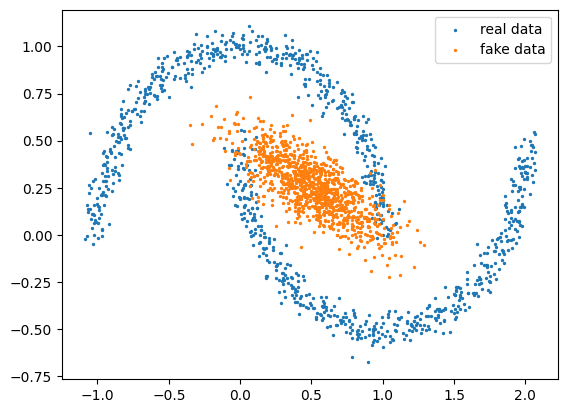

step 9000: discriminator: 1.386e+00, generator: 6.930e-01


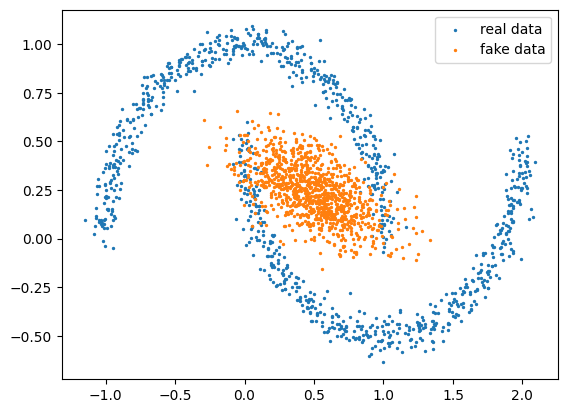

step 10000: discriminator: 1.386e+00, generator: 6.933e-01


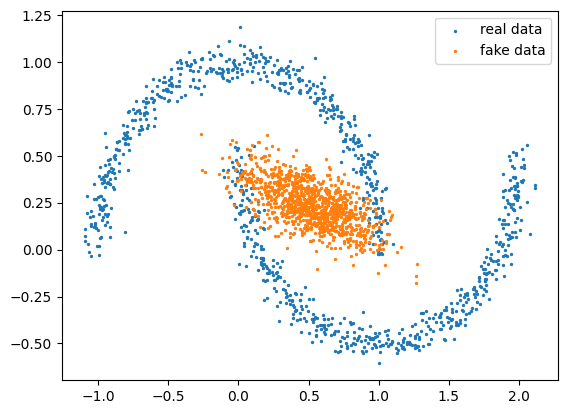

step 11000: discriminator: 1.386e+00, generator: 6.930e-01


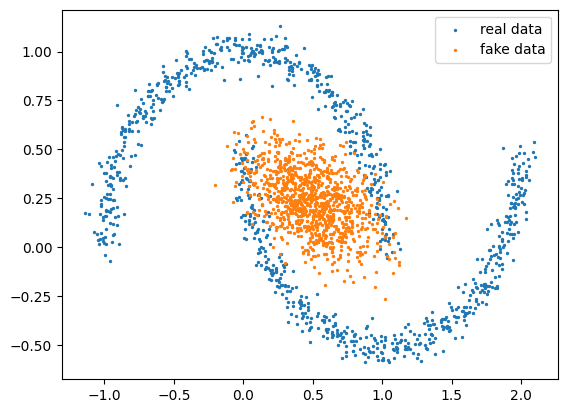

step 12000: discriminator: 1.386e+00, generator: 6.931e-01


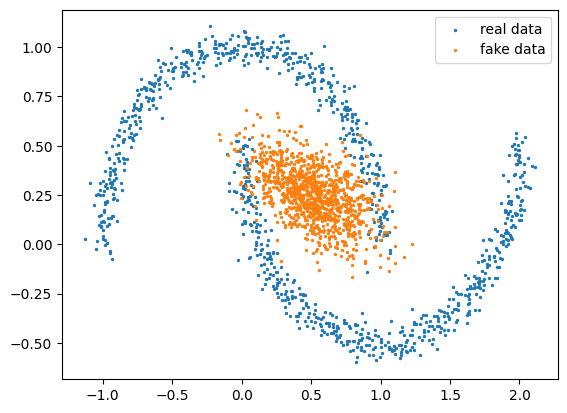

step 13000: discriminator: 1.386e+00, generator: 6.930e-01


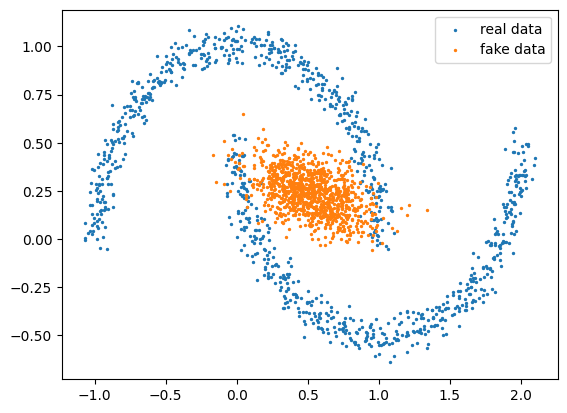

step 14000: discriminator: 1.386e+00, generator: 6.930e-01


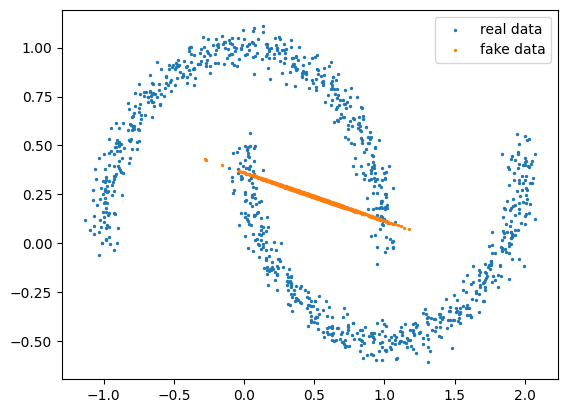

step 15000: discriminator: 1.386e+00, generator: 6.931e-01


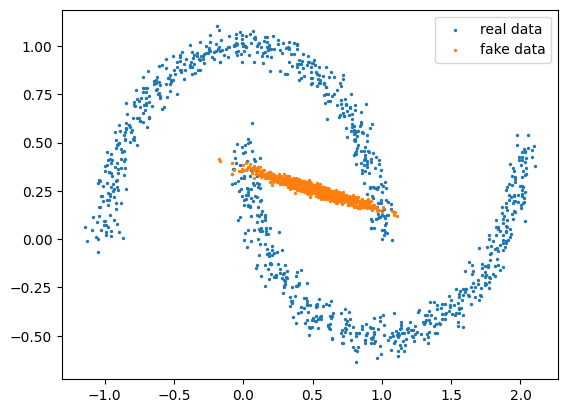

step 16000: discriminator: 1.386e+00, generator: 6.930e-01


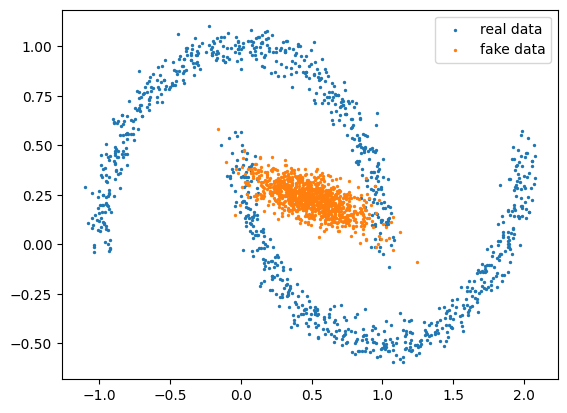

step 17000: discriminator: 1.386e+00, generator: 6.931e-01


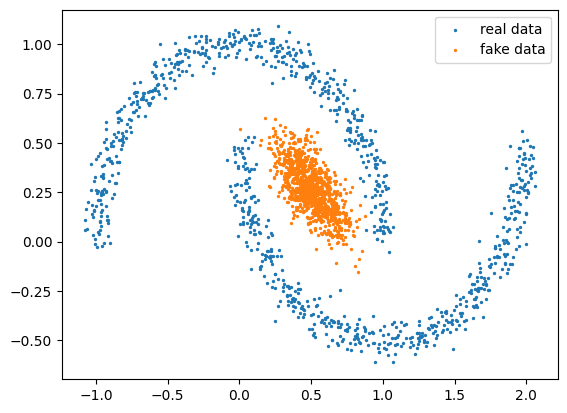

step 18000: discriminator: 1.386e+00, generator: 6.932e-01


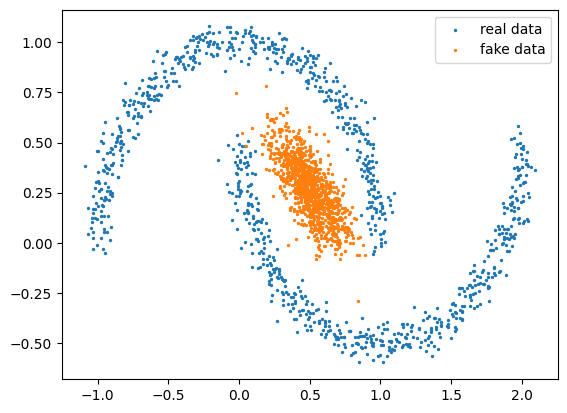

step 19000: discriminator: 1.386e+00, generator: 6.934e-01


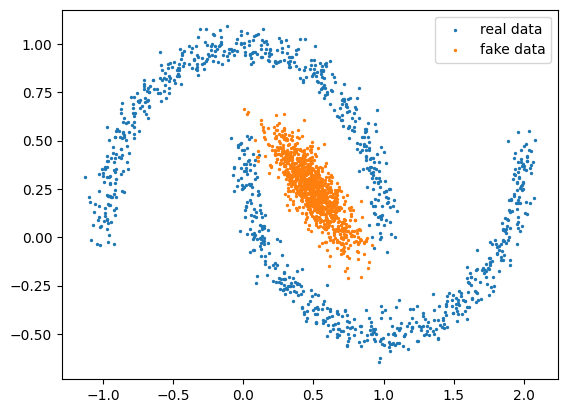

step 20000: discriminator: 1.386e+00, generator: 6.931e-01


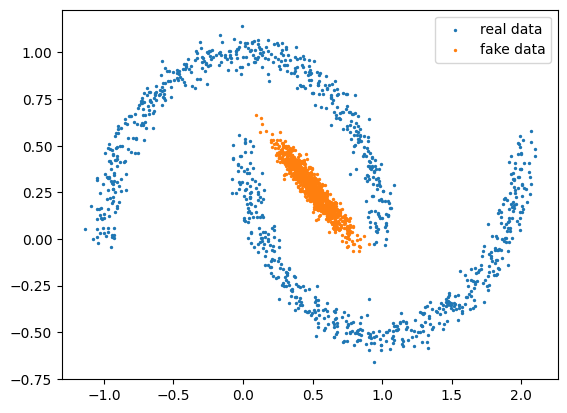

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        real_pred = discriminator(real_batch)
        fake_pred = discriminator(fake_batch)
        real_loss = F.binary_cross_entropy_with_logits(real_pred, torch.ones_like(real_pred))
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred))
        disc_loss = real_loss + fake_loss
        #
        #disc_loss = 0
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    fake_pred = discriminator(fake_batch)
    gen_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.ones_like(fake_pred))

    #
    #gen_loss = 0
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

We could anticipate that the generator's loss $\mathcal{L}_G = \mathbb{E}{p_\theta} \log(1-D(x))$ might cause issues because it only provides feedback based on samples generated by the generator itself, without considering the real data distribution.

At the beginning of the training, the discriminator is not very good at distinguishing between real and fake samples, so its output may not provide useful gradients for the generator. Moreover, when the discriminator becomes better at discriminating between real and fake samples, the generator's loss may saturate or get very close to 0, which could lead to vanishing gradients.

As a solution we can replace the loss with $\mathcal{L}_G = \mathbb{E}{p_\theta} [-\log(D(x))]$

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

def generate_batch(batchlen):
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

PRIOR_N = 2

class Generator(nn.Module):
    def __init__(self, depth, width):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(PRIOR_N, width))
        for _ in range(depth - 1):
            self.layers.append(nn.Linear(width, width))
        self.layers.append(nn.Linear(width, 2))

    def forward(self, z):
        x = z
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.forward(z)

class Discriminator(nn.Module):
    def __init__(self, depth, width):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, width))
        for _ in range(depth - 1):
            self.layers.append(nn.Linear(width, width))
        self.layers.append(nn.Linear(width, 1))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)

In [ ]:
def train_gan(gen_depth, gen_width, disc_depth, disc_width, train_ratio, n_iter=20001, batchlen=128):
    generator = Generator(gen_depth, gen_width)
    optim_gen = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))
    discriminator = Discriminator(disc_depth, disc_width)
    optim_disc = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.9))

    for i in range(n_iter):
        # train the discriminator
        for _ in range(train_ratio):
            discriminator.zero_grad()
            real_batch = generate_batch(batchlen)
            fake_batch = generator.generate(batchlen)

            real_pred = discriminator(real_batch)
            fake_pred = discriminator(fake_batch)

            real_loss = F.binary_cross_entropy_with_logits(real_pred, torch.ones_like(real_pred))
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred))
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            optim_disc.step()

        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(batchlen)
        fake_pred = discriminator(fake_batch)

        gen_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.ones_like(fake_pred))
        gen_loss.backward()
        optim_gen.step()

        if i % 1000 == 0:
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))

    # plot the result
    real_batch = generate_batch(1024)
    fake_batch = generator.generate(1024).detach()
    plt.scatter(real_batch[:, 0], real_batch[:, 1], s=2.0, label='real data')
    plt.scatter(fake_batch[:, 0], fake_batch[:, 1], s=2.0, label='fake data')
    plt.legend()
    plt.show()

# Starting experiment
for train_ratio in [1,4,7]:
  for gen_depth in [2,8,12]:
    for disc_depth in [2,10,20]:
      for disc_width in [15,64,128]:
        print('Parameters: TRAIN_RATIO {}, gen_depth {}, disc_depth {}, disc_width {}'.format(TRAIN_RATIO, gen_depth, disc_depth, disc_width))
        train_gan(gen_depth=gen_depth, gen_width=64, disc_depth=disc_depth, disc_width=disc_width, train_ratio=1)
        print()
        print("################## NEXT ######################")
        print()


In this experiment we created 4 loops:


    for train_ratio in [1,4,7]:
      for gen_depth in [2,8,12]:
          for disc_depth in [2,10,20]:
              for disc_width in [15,64,128]:


- **train_ratio**: This parameter controls how many times we train the discriminator for each generator training step. A smaller value means the generator and discriminator are trained more evenly. A larger value means the discriminator is trained more often, so it becomes better at distinguishing real and fake samples. But if the discriminator is too strong, the generator can have a hard time learning.

- **gen_depth**: This parameter controls the depth of the generator network. A deeper network can learn more complex functions, but it can also be harder to train. If the depth is too small, the generator may not learn well enough to produce realistic samples. If the depth is too large, training can become slow and the network may overfit.

- **disc_depth**: This parameter controls the depth of the discriminator network. Similar to the generator depth, a deeper discriminator can learn more complex functions to distinguish between real and fake samples. However, if the discriminator is too deep, it may become too strong, making it difficult for the generator to learn.

- **disc_width**: This parameter controls the width of the discriminator network. A wider network can learn more complex features, but it can also be harder to train and may require more computation. If the width is too small, the discriminator may not learn well enough to distinguish between real and fake samples. If the width is too large, training can become slow and the network may overfit.



For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

To prove the equivalence between maximizing the likelihood $\mathbb{E}{p_D} \left[\log p\theta(x) \right]$ and minimizing the KL-divergence $D_{KL}(p_D | p_\theta)$, we will start by expanding the KL-divergence definition and then simplify the expression.

\begin{align*}
D_{KL}(p_D | p_\theta) = \mathbb{E}{p_D}\left[ log(\frac{p_D}{p\theta}) \right] \
= \mathbb{E}{p_D}\left[ log(p_D) - log(p\theta) \right] \
= \int p_D(x) log(p_D(x)) dx - \int p_D(x) log(p_\theta(x)) dx,
\end{align*}

Since left term doesn't depend on $p_\theta$, minimizing $D_{KL}(p_D | p_\theta)$ is equivalent to minimizing the second term.

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

The prior distribution, $p(z)$, isn't sampled directly in VAE training. This might make a problem for the data the model generates, because the model isn't forced to make samples that follow the prior distribution. Instead, the KL-divergence term in the ELBO loss tries to make the approximate posterior distribution $q_\phi(z|x)$ close to the prior $p(z)$.

Since $p(z)$ isn't sampled during training, the generator may not use the whole latent space according to the prior. So, the generated data might not have all the possible variations in the training data. This could lead to a limited representation of the data distribution, and the generated samples might not be diverse or show the true data distribution well.

In practice, the regularization term in the ELBO loss (the KL-divergence between $q_\phi(z|x)$ and $p(z)$) helps to fix this problem. By minimizing this term, the model is pushed to use the latent space well, making $q_\phi(z|x)$ close to the prior distribution $p(z)$. So, even if $p(z)$ isn't sampled during training, the model learns to generate data that matches the real data distribution.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

Assuming $q_\phi(z | x)$ is a Gaussian distribution, we can represent it as $\mathcal{N}(\mu_\phi(x); \Sigma_\phi(x))$, where $\mu_\phi(x)$ is the mean and $\Sigma_\phi(x)$ is the covariance matrix, both of which are functions of $x$ and depend on the parameters $\phi$.

Now, we have $p(z) = \mathcal{N}(0; Id)$, where $Id$ is the identity matrix. To compute the KL-divergence between the two Gaussian distributions, we can use the following formula:

$$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \left( \text{Tr}(\Sigma_\phi^{-1}(x) Id) + (\mu_\phi(x) - 0)^T Id (\mu_\phi(x) - 0) - k + \log \frac{|Id|}{|\Sigma_\phi(x)|} \right),$$

where $k$ is the dimensionality of the latent space, Tr denotes the trace of a matrix, and $|\cdot|$ denotes the determinant of a matrix.

In this particular case, since $p(z)$ has an identity covariance matrix, the formula simplifies to:

$$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \left( \text{Tr}(\Sigma_\phi(x)) + \mu_\phi(x)^T \mu_\phi(x) - k + \log \frac{1}{|\Sigma_\phi(x)|} \right).$$

This is the KL-divergence between the Gaussian distribution $q_\phi(z | x)$ and the standard Gaussian distribution $p(z)$. Note that the actual value of the KL-divergence depends on the functions $\mu_\phi(x)$ and $\Sigma_\phi(x)$, which are determined by the neural network with parameters $\phi$.


We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

We assume that $p_\theta(x | z)$ is Gaussian distribution: $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$, where $\mu_\theta(z)$ is mean and $\sigma_\theta(z)$ is covariance matrix, both depending on $z$ and parameters $\theta$.

For Gaussian distribution, probability density function (pdf) is:

$$p(x) = \frac{1}{\sqrt{(2\pi)^k |\Sigma|}} \exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right),$$

where $k$ is dimensionality of space, $|\Sigma|$ is determinant of covariance matrix, and $\mu$ is mean.

For our case, we can write pdf of $p_\theta(x | z)$:

$$p_\theta(x | z) = \frac{1}{\sqrt{(2\pi)^k |\sigma_\theta(z)|}} \exp \left( -\frac{1}{2} (x - \mu_\theta(z))^T \sigma_\theta^{-1}(z) (x - \mu_\theta(z)) \right).$$

Now we find negative log-likelihood for $p_\theta(x | z)$:

$$-\log p_\theta(x | z) = \frac{k}{2} \log (2\pi) + \frac{1}{2} \log |\sigma_\theta(z)| + \frac{1}{2} (x - \mu_\theta(z))^T \sigma_\theta^{-1}(z) (x - \mu_\theta(z)).$$



We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)

    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)


# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

step 0: KL: 4.283e+00, rec: 2.443e+03


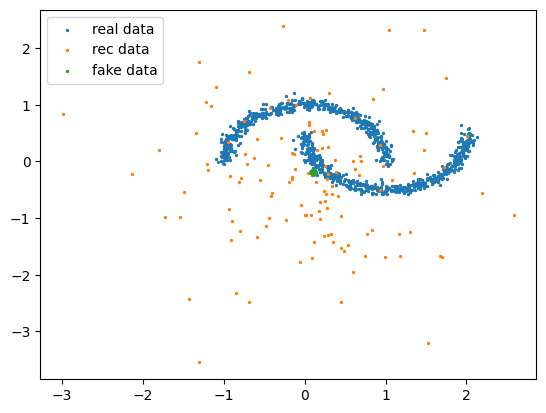

step 1000: KL: 1.410e+02, rec: 2.172e+03


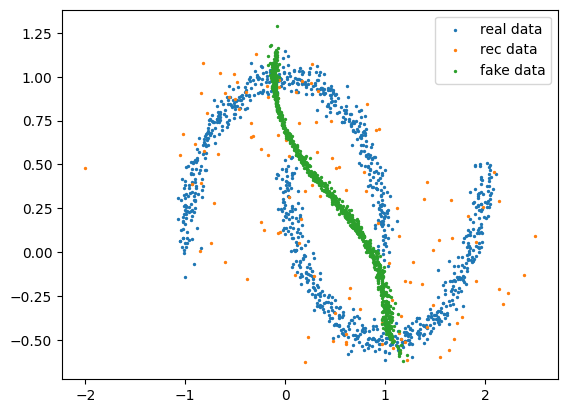

step 2000: KL: 1.473e+02, rec: 2.166e+03


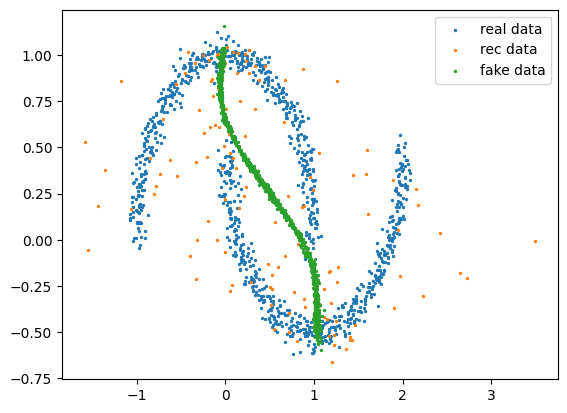

step 3000: KL: 1.538e+02, rec: 2.164e+03


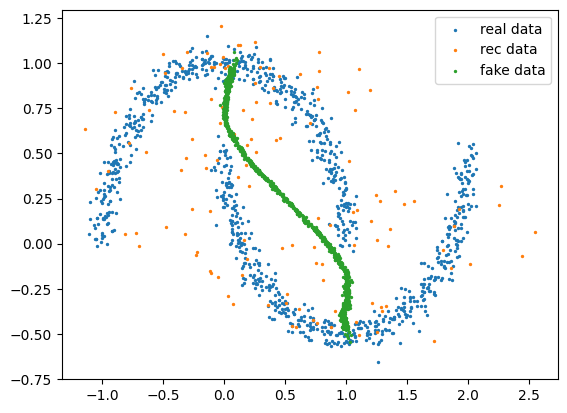

step 4000: KL: 1.582e+02, rec: 2.153e+03


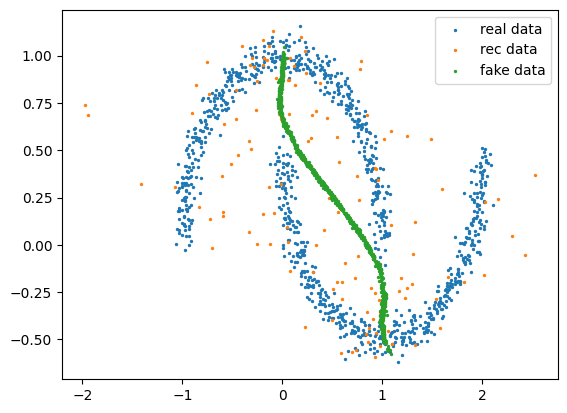

step 5000: KL: 1.705e+02, rec: 2.126e+03


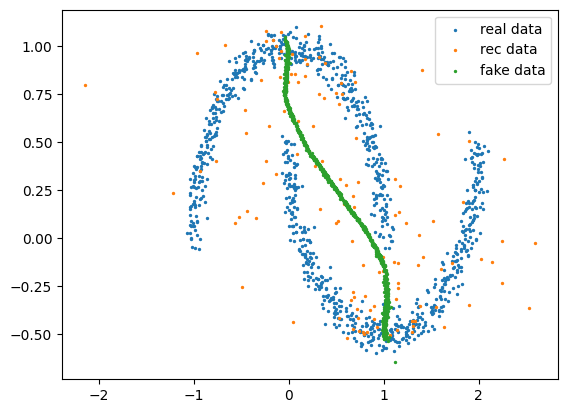

step 6000: KL: 1.707e+02, rec: 2.158e+03


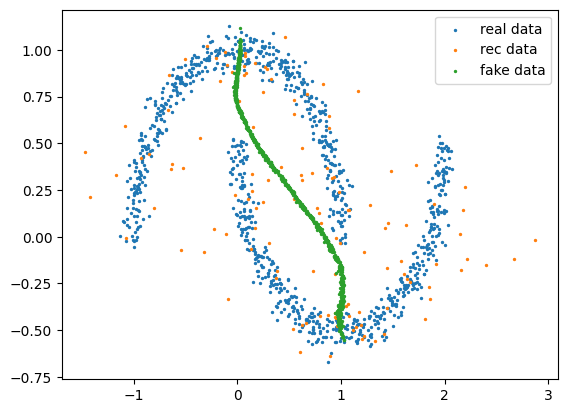

step 7000: KL: 1.703e+02, rec: 2.111e+03


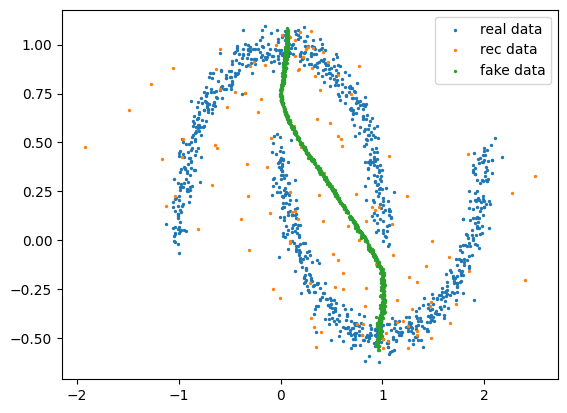

step 8000: KL: 1.742e+02, rec: 2.140e+03


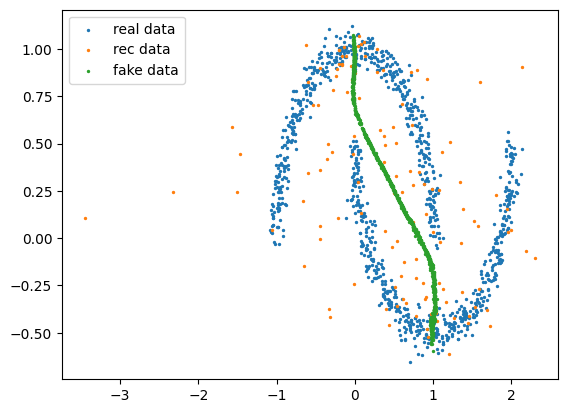

step 9000: KL: 1.740e+02, rec: 2.136e+03


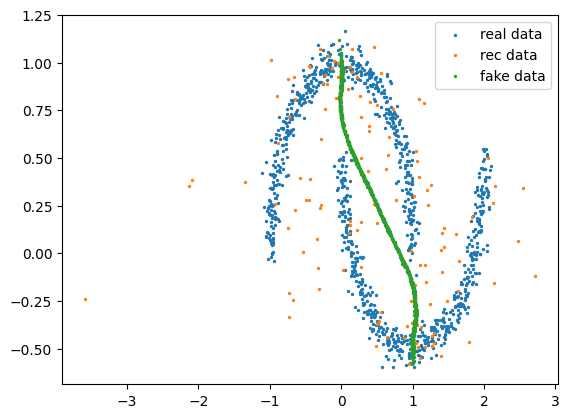

step 10000: KL: 1.828e+02, rec: 2.118e+03


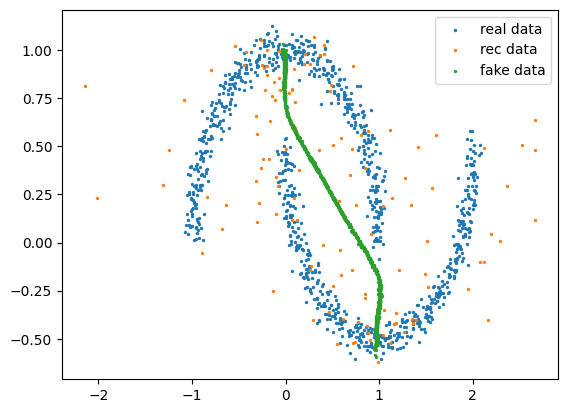

step 11000: KL: 1.932e+02, rec: 2.121e+03


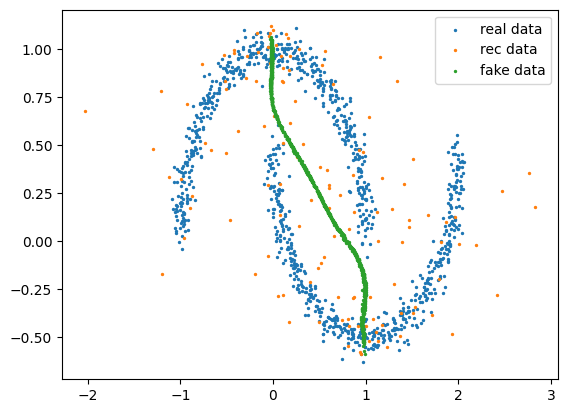

step 12000: KL: 1.827e+02, rec: 2.128e+03


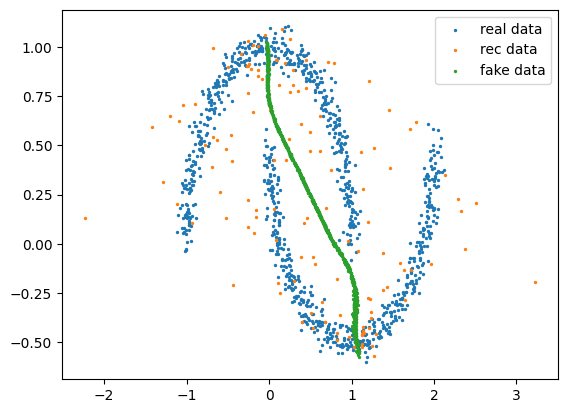

step 13000: KL: 1.885e+02, rec: 2.109e+03


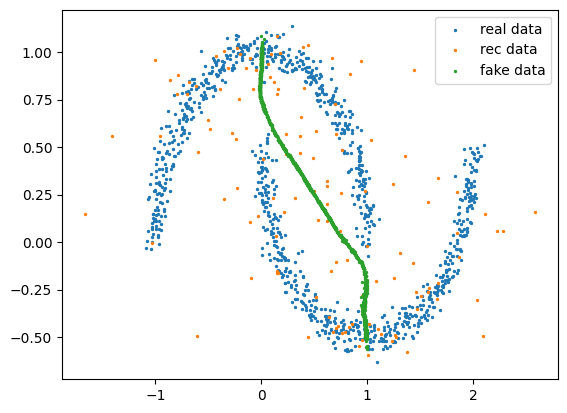

step 14000: KL: 1.934e+02, rec: 2.115e+03


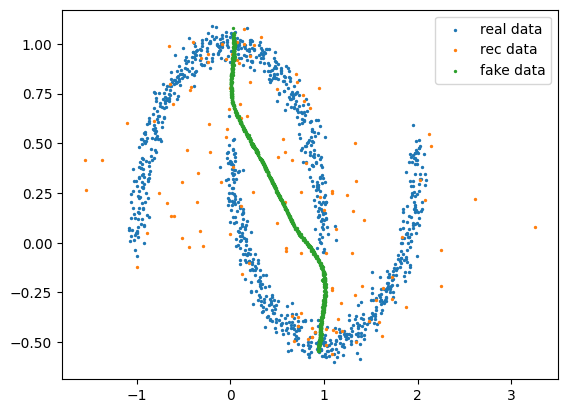

step 15000: KL: 1.992e+02, rec: 2.096e+03


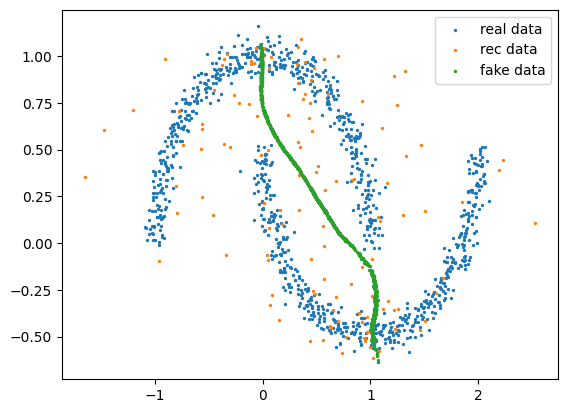

step 16000: KL: 1.934e+02, rec: 2.115e+03


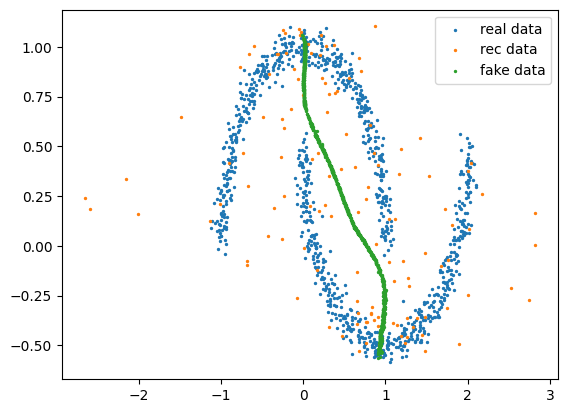

step 17000: KL: 1.952e+02, rec: 2.104e+03


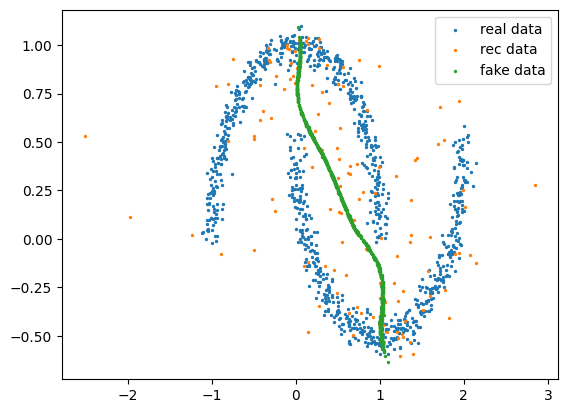

step 18000: KL: 1.968e+02, rec: 2.124e+03


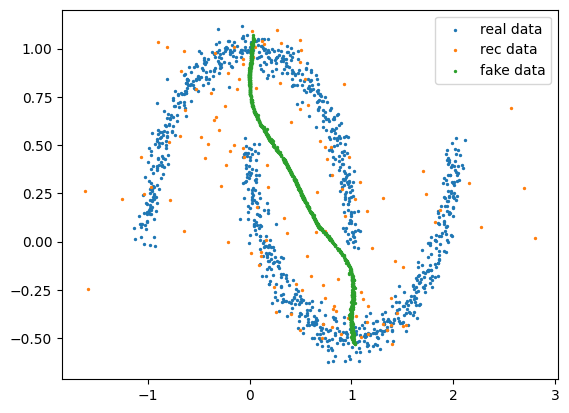

step 19000: KL: 2.056e+02, rec: 2.102e+03


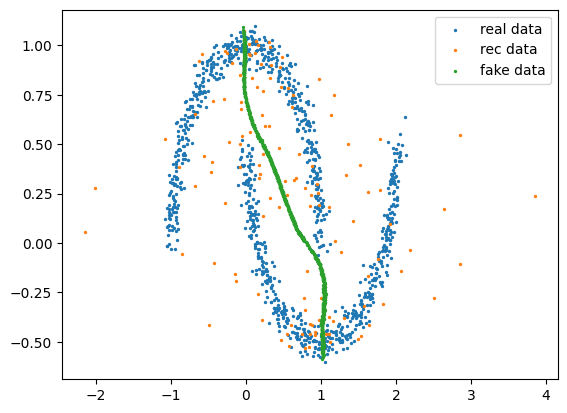

step 20000: KL: 2.038e+02, rec: 2.108e+03


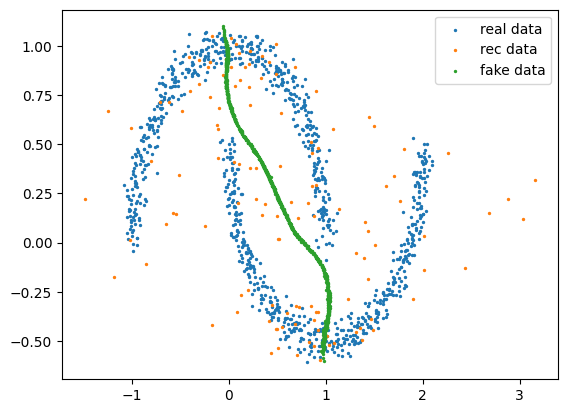

step 21000: KL: 2.007e+02, rec: 2.115e+03


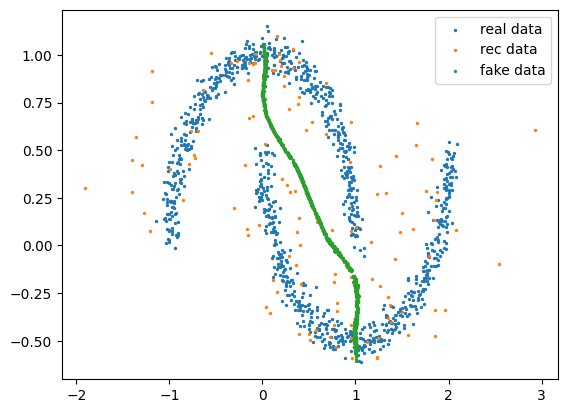

step 22000: KL: 2.012e+02, rec: 2.103e+03


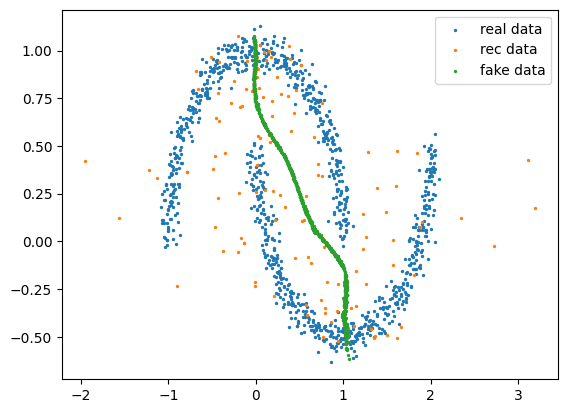

step 23000: KL: 2.002e+02, rec: 2.110e+03


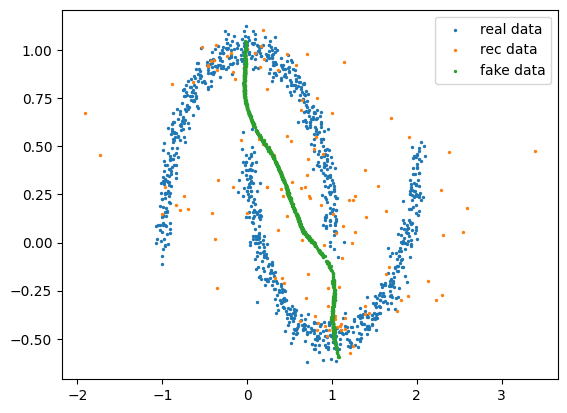

step 24000: KL: 1.973e+02, rec: 2.112e+03


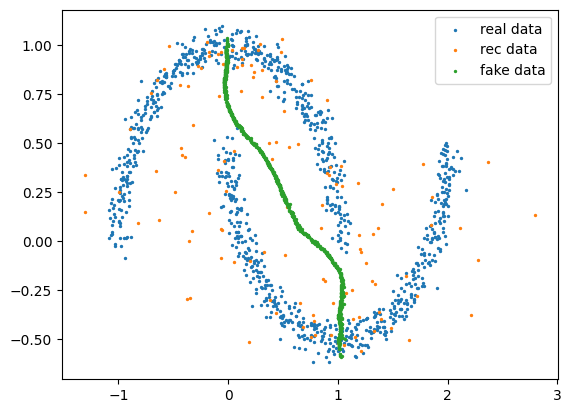

step 25000: KL: 2.060e+02, rec: 2.096e+03


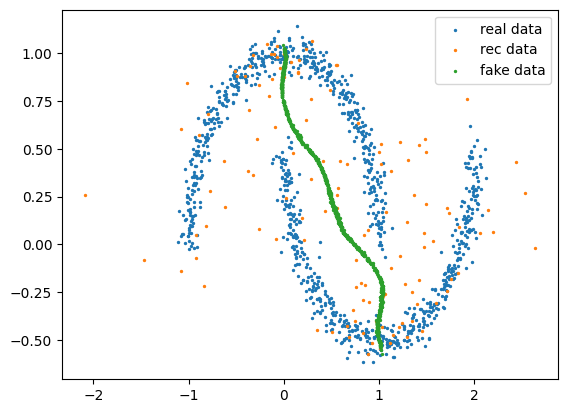

step 26000: KL: 2.035e+02, rec: 2.086e+03


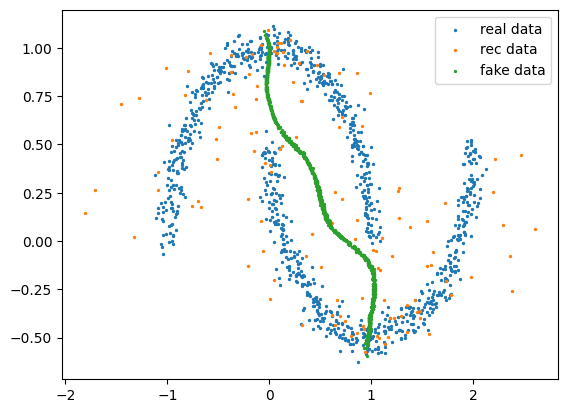

step 27000: KL: 2.095e+02, rec: 2.100e+03


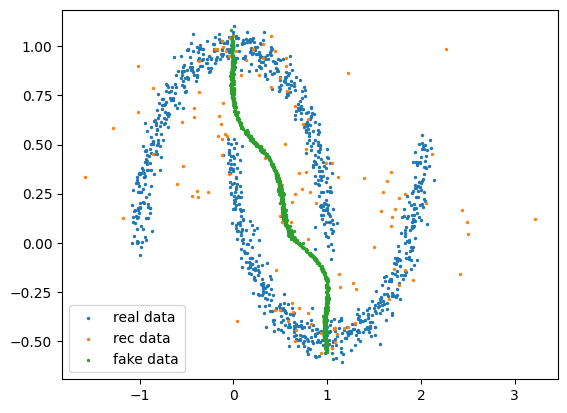

step 28000: KL: 2.052e+02, rec: 2.098e+03


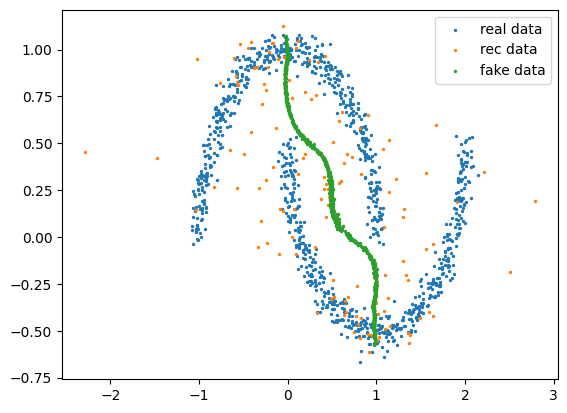

step 29000: KL: 2.083e+02, rec: 2.096e+03


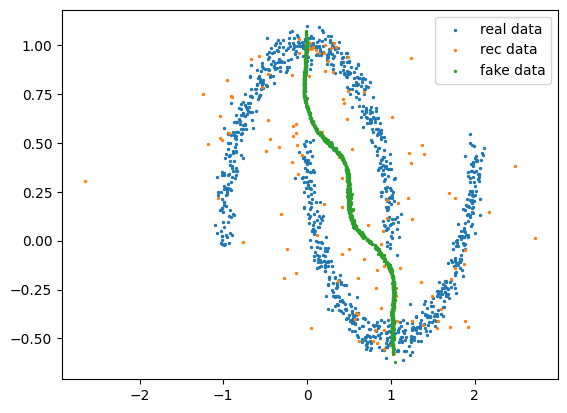

step 30000: KL: 2.127e+02, rec: 2.086e+03


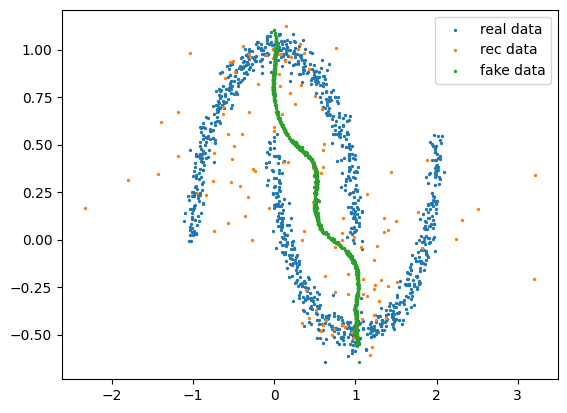

step 31000: KL: 2.077e+02, rec: 2.128e+03


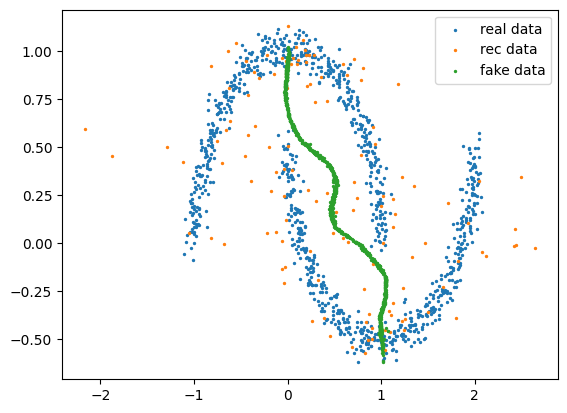

step 32000: KL: 2.120e+02, rec: 2.087e+03


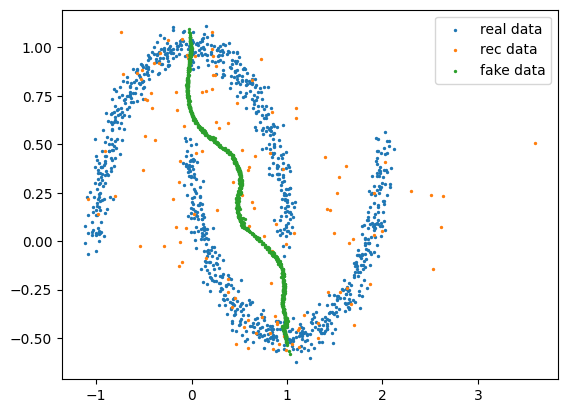

step 33000: KL: 2.029e+02, rec: 2.120e+03


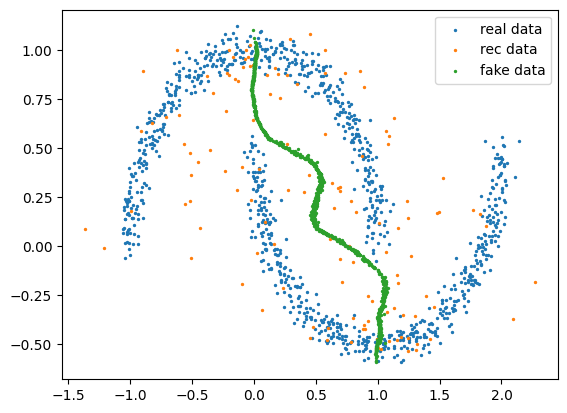

step 34000: KL: 2.103e+02, rec: 2.088e+03


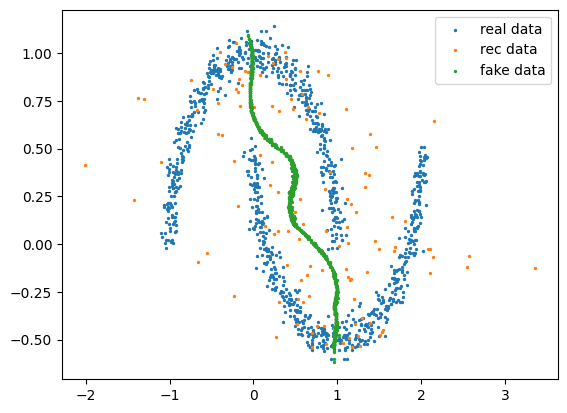

step 35000: KL: 2.131e+02, rec: 2.080e+03


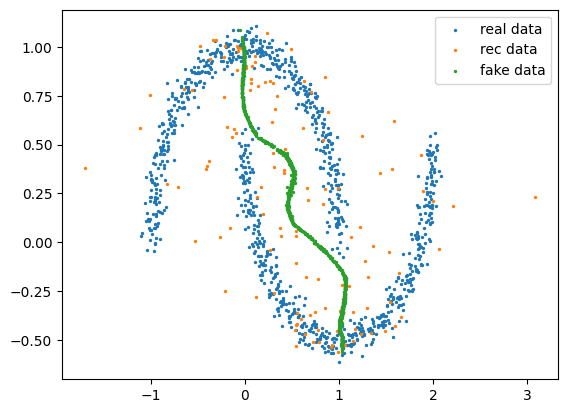

step 36000: KL: 2.190e+02, rec: 2.090e+03


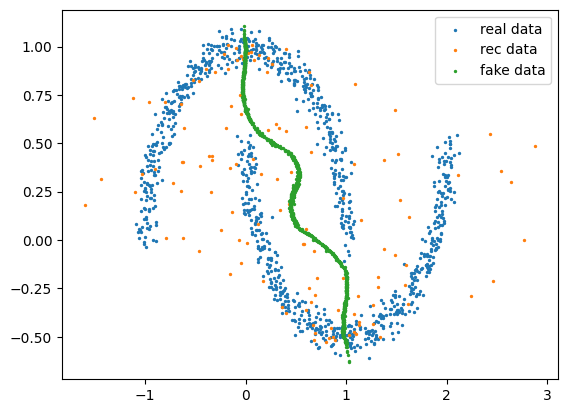

step 37000: KL: 2.155e+02, rec: 2.078e+03


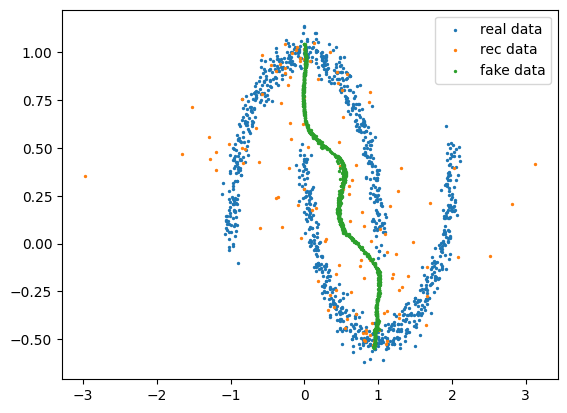

step 38000: KL: 2.208e+02, rec: 2.089e+03


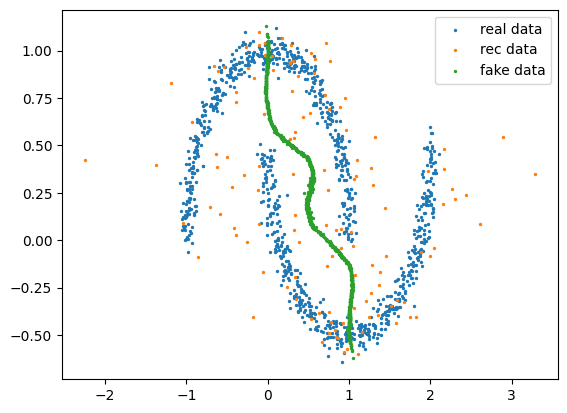

step 39000: KL: 2.131e+02, rec: 2.100e+03


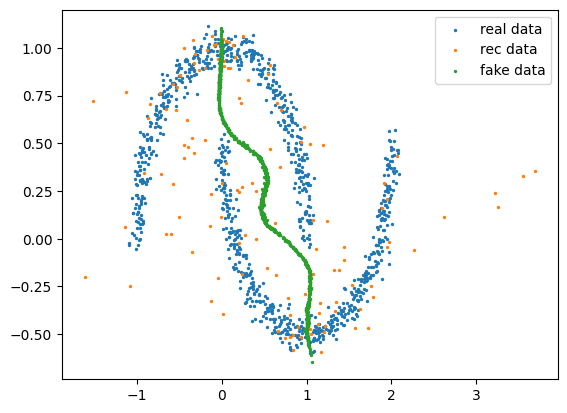

step 40000: KL: 2.160e+02, rec: 2.097e+03


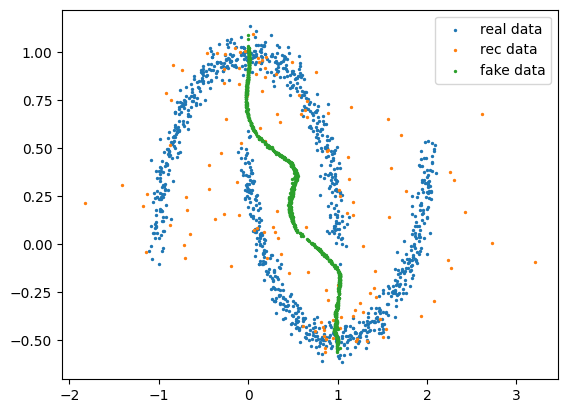

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_batch(BATCHLEN)

    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * torch.sum(torch.exp(enc_logvar) + enc_mu.pow(2) - 1 - enc_logvar)

    #
    # SAMPLE z FROM q(z|x) HERE
    #
    enc_sig = torch.exp(0.5*enc_logvar)
    z = enc_mu + enc_sig * torch.randn(BATCHLEN, LATENT_N)


    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * torch.sum(dec_logvar + (x - dec_mu).pow(2) * torch.exp(-dec_logvar) + LATENT_N * np.log(2 * np.pi))

    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

We first try to solve this problem with modifying encoder with 8 layers with 128 hidden size. Then, we faced overfitting problems. After that, we modified it with **6 layers** instead which gave obviously better results.

__Architecture:__

The updated Variational Autoencoder (VAE) has an Encoder and a Decoder. Both have 6 added hidden layers.

The Encoder takes a 2D input and maps it to a space with LATENT_N dimensions. It has n_layers connected layers with a ReLU activation after each one, except for the last layer. The output from these layers goes through two separate connected layers to get the mean ($\mu$) and log-variance (logvar) of the Gaussian distribution $q_\phi(z|x)$.

The Decoder maps the space back to the original data. It's similar to the Encoder, with n_layers connected layers and ReLU activations, except for the last layer. The output goes through two separate connected layers to get the mean ($\mu$) and log-variance (logvar) of the Gaussian distribution $p_\theta(x|z)$.

The generate function in the Decoder takes a batch of random samples from the prior distribution $p(z)$ (a standard Gaussian) and makes data points by adding small noise with fixed variance (1e-4) to the mean ($\mu$) from the Decoder.

---
We observe that the modified architecture leads to improved results compared to the original one. Additionally, when the variance is set too low, both the fake and reconstructed data closely resemble the two-moon distribution. Interestingly, the fake data almost perfectly mirrors the reconstructed data in this scenario.

However, one concern is that the learning process appears to be unstable. At certain stages, the fake data deviates from the two-moon distribution, indicating that it is highly sensitive to changes in the reconstructed data when the variance is too small.

This raises the possibility that the fake data could be overfitting to the reconstructed data and might struggle to generalize well to the training data. In this case, it's important to carefully consider the balance between fitting the data distribution and preventing overfitting to ensure a robust and accurate model.


step 0: KL: 3.602e+00, rec: 2.434e+03


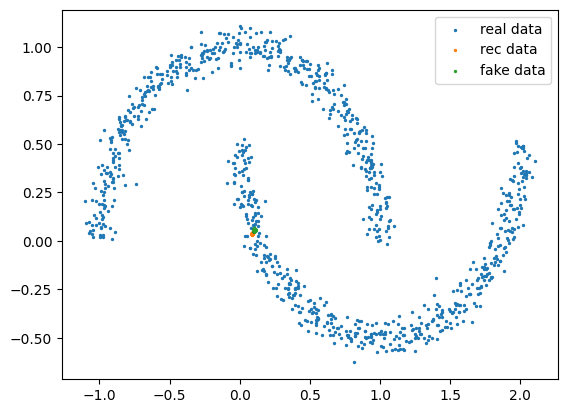

step 1000: KL: 3.851e+02, rec: 1.979e+03


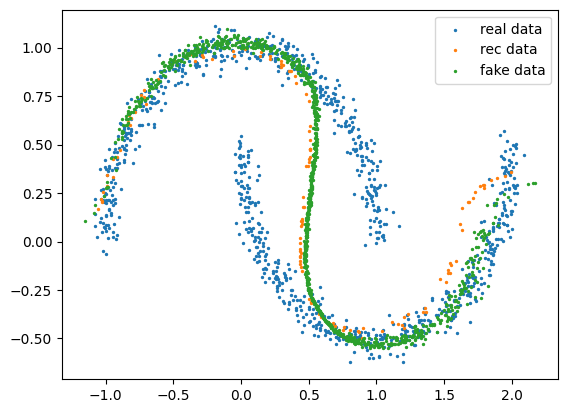

step 2000: KL: 4.483e+02, rec: 1.889e+03


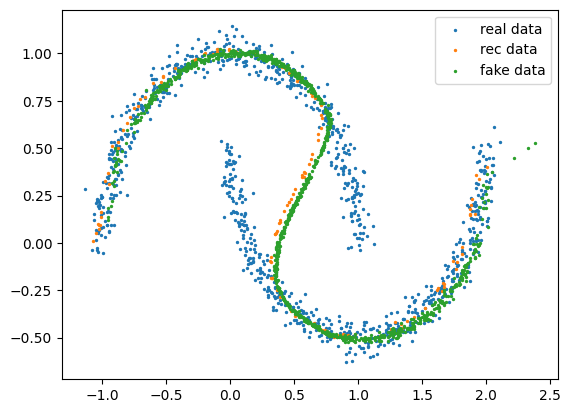

step 3000: KL: 4.443e+02, rec: 1.845e+03


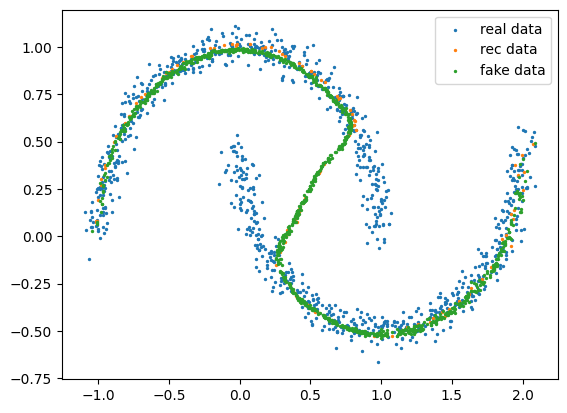

step 4000: KL: 4.882e+02, rec: 1.893e+03


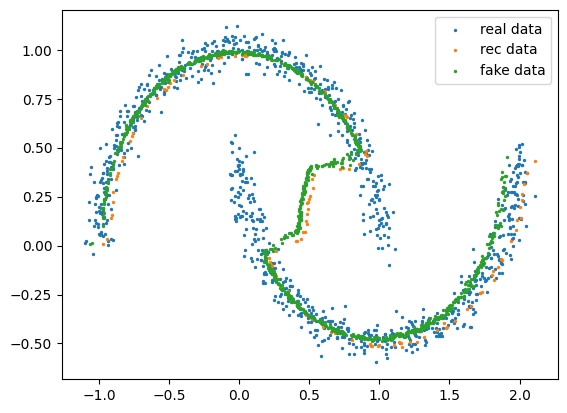

step 5000: KL: 5.030e+02, rec: 1.812e+03


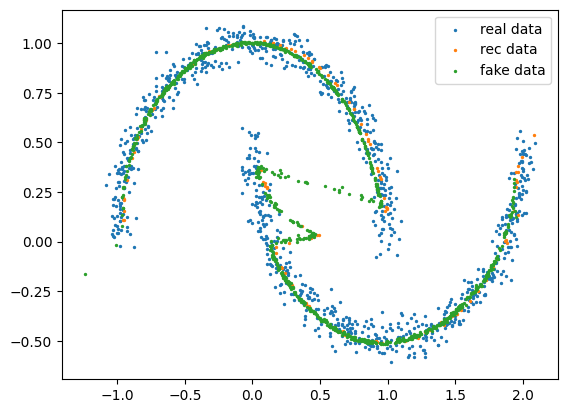

step 6000: KL: 5.277e+02, rec: 1.747e+03


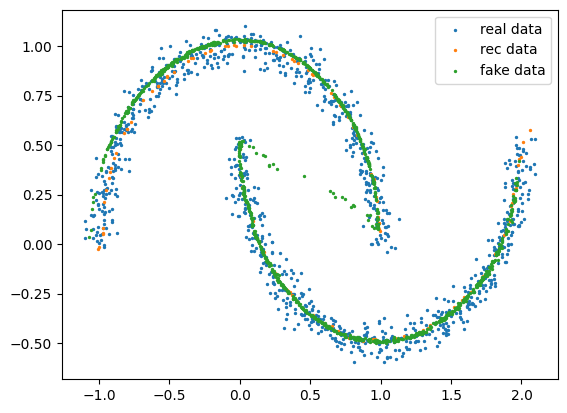

step 7000: KL: 5.329e+02, rec: 1.787e+03


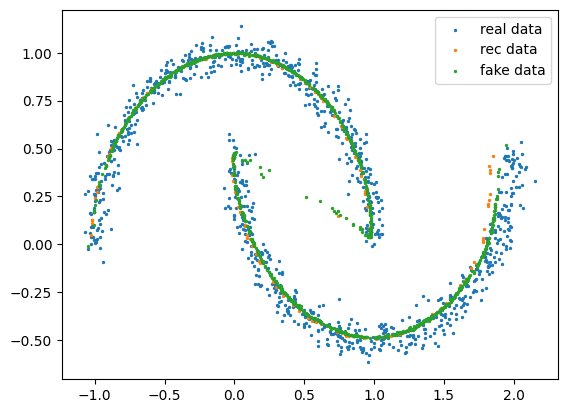

step 8000: KL: 5.156e+02, rec: 1.746e+03


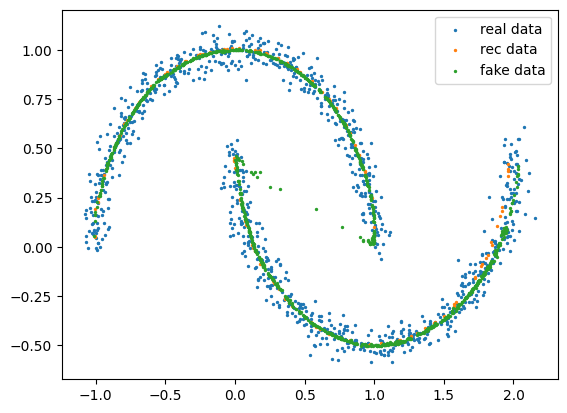

step 9000: KL: 5.201e+02, rec: 1.777e+03


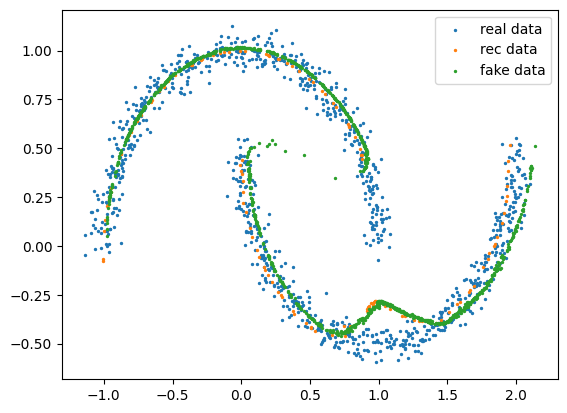

step 10000: KL: 4.997e+02, rec: 1.848e+03


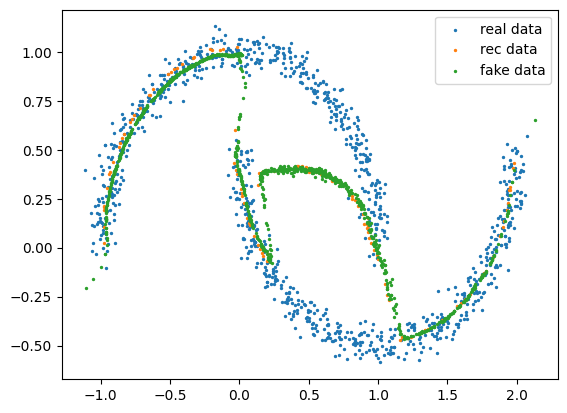

step 11000: KL: 5.122e+02, rec: 1.797e+03


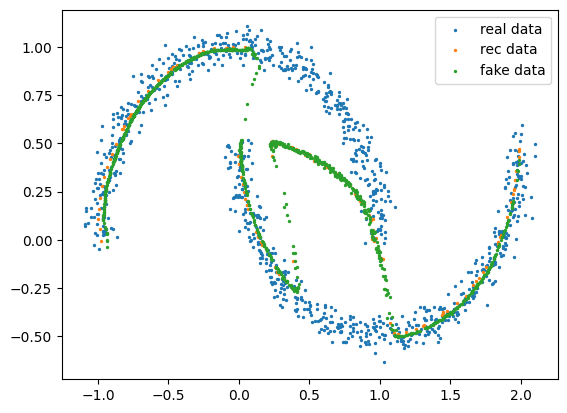

step 12000: KL: 5.406e+02, rec: 1.835e+03


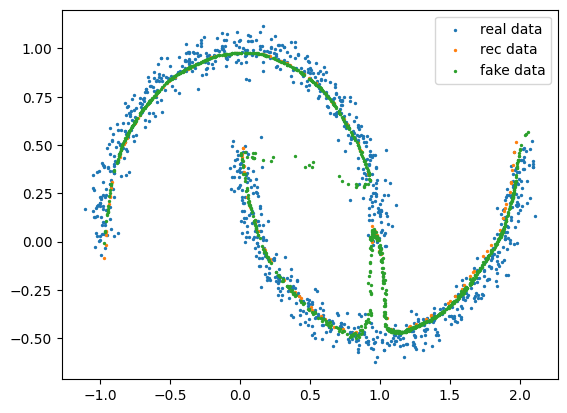

step 13000: KL: 5.264e+02, rec: 1.758e+03


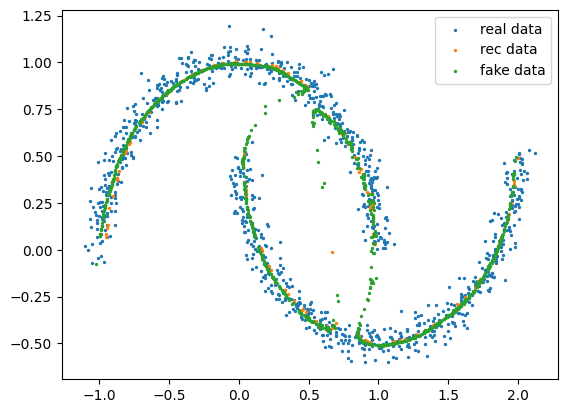

step 14000: KL: 5.377e+02, rec: 1.823e+03


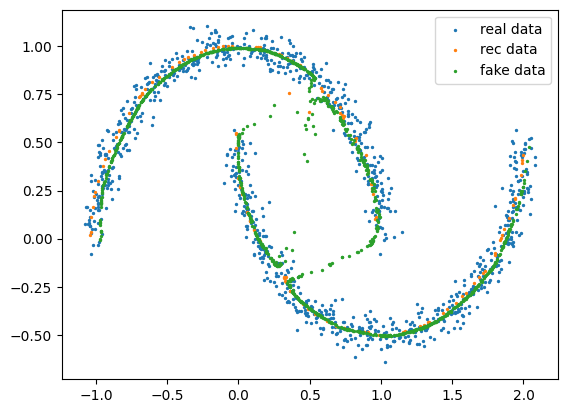

step 15000: KL: 5.485e+02, rec: 1.727e+03


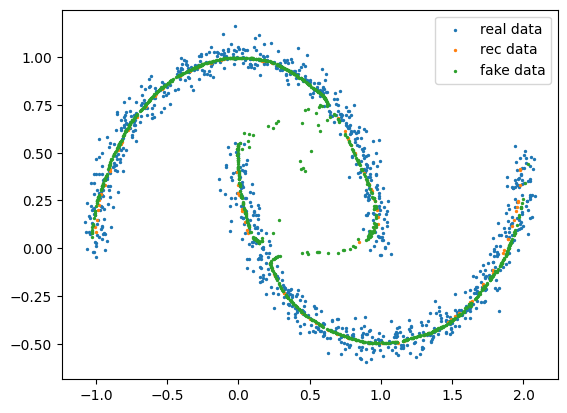

step 16000: KL: 5.481e+02, rec: 1.701e+03


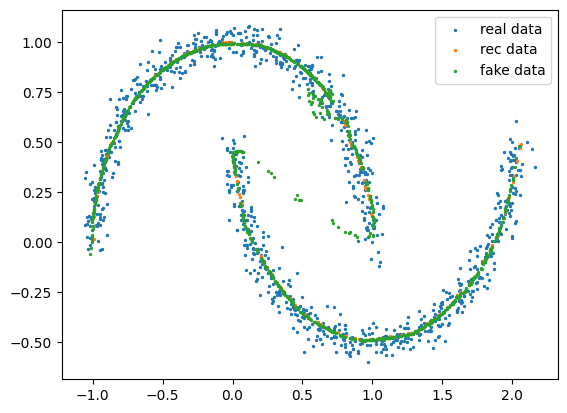

step 17000: KL: 5.657e+02, rec: 1.687e+03


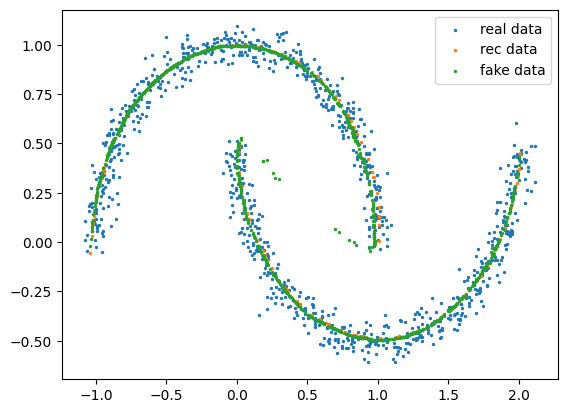

step 18000: KL: 5.492e+02, rec: 1.729e+03


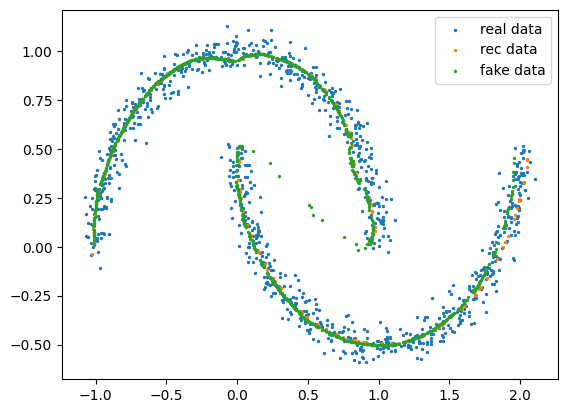

step 19000: KL: 5.451e+02, rec: 1.769e+03


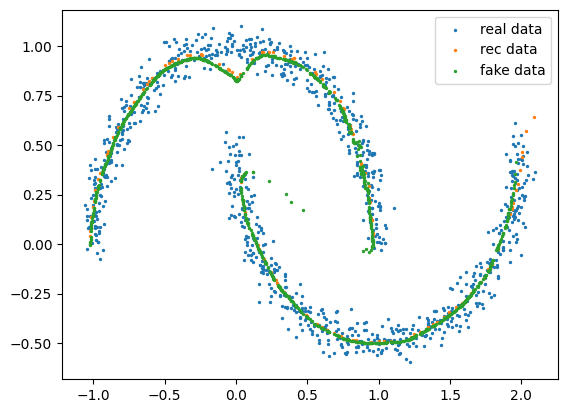

step 20000: KL: 5.366e+02, rec: 1.735e+03


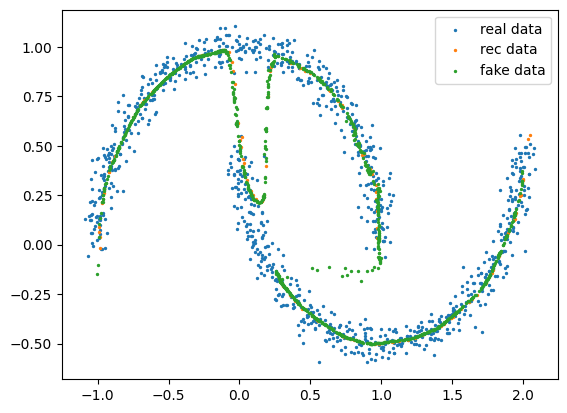

In [ ]:
LATENT_N = 10

# Modified generator architecture
class Encoder(nn.Module):
    def __init__(self, n_layers = 6, hidden_size = 128):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.layers = [nn.Linear(2, self.hidden_size), nn.ReLU()]

        for i in range(1, self.n_layers):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(nn.ReLU())

        self.fc = nn.Sequential(*self.layers)
        self.fc_mu = nn.Linear(self.hidden_size, LATENT_N)
        self.fc_logvar = nn.Linear(self.hidden_size, LATENT_N)

    def __call__(self, x):
        x = self.fc(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)

# Modified discriminator architecture
class Decoder(nn.Module):
    def __init__(self, n_layers=6, hidden_size=128):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.layers = [nn.Linear(LATENT_N, self.hidden_size), nn.ReLU()]

        for i in range(1, self.n_layers):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(nn.ReLU())

        self.fc = nn.Sequential(*self.layers)
        self.fc_mu = nn.Linear(self.hidden_size, 2)
        self.fc_logvar = nn.Linear(self.hidden_size, 2)

    def __call__(self, z):
        z = self.fc(z)
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, 1e-4)


# Total number of training iterations for the VAE
N_ITER = 20001

# Batch size
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))

decoder = Decoder()

optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_batch(BATCHLEN)

    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * torch.sum( torch.exp(enc_logvar) + enc_mu.pow(2) - 1 - enc_logvar)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    enc_sig = torch.exp(0.5*enc_logvar)
    z = enc_mu + enc_sig * torch.randn((BATCHLEN,LATENT_N))
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * torch.sum(dec_logvar + (x - dec_mu).pow(2) * torch.exp(-dec_logvar) + LATENT_N * np.log(2 * np.pi))

    (0.25*loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, 1e-4).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()



**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> The power of the Encoder and Decoder in a Variational Autoencoder (VAE) is very important for the training and performance of the model.

- **Encoder:** The Encoder's job is to change the input data into a different representation called latent space. If the Encoder is too strong, it might learn the data too well, causing overfitting. This means that the VAE won't work well with new, unseen data. If the Encoder is too weak, it might not learn the important features of the data, which can make the Decoder's job harder and limit the overall quality of the samples made by the VAE.

- **Decoder:** The Decoder's job is to change the latent space representation back into the original data. A strong Decoder can create high-quality samples, which helps in learning a better latent space. However, if the Decoder is too strong, it might just memorize the input data and not use the latent space properly, resulting in poor generalization. If the Decoder is too weak, it might not create accurate samples, leading to a VAE that generates low-quality samples.

It's important to balance the power of the Encoder and Decoder for the VAE to work well. The Encoder should be strong enough to understand the main features of the input data, and the Decoder should be able to recreate the input without overfitting or ignoring the latent space. This balance helps the VAE learn a useful latent space representation that can create high-quality samples and still work well with new data.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$.
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

Let us introduce the definition of the image of a probability distribution through a bijective mapping:

$$\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x) $$

We choose the function $g(x)$ such that $g(x) = 1$ if $x \in H$, and $g(x) = 0$ otherwise where $H$ is a part of dataset . Let's call the corresponding region in the latent space $\mathcal{Z}$ as $S = f(R)$. Then, we have:

$$\int_{S} dp_\mathcal{N}(z) = \int_{H} dp_{G}(x) $$

Apply the change of variables on the left-hand side, replacing $z$ with $f(x)$ and applying the Jacobian transformation:

$$\int_{H} dp_{G}(x) = \int_{H} \lvert \det J_f(x) \rvert dp_\mathcal{N}(f(x))$$

Divide both sides by the volume of the region $H$ and take the limit as the volume of $H$ goes to zero. This gives the probability density functions of the distributions at the point $x$:

$$p_{G}(x) = \lvert \det J_f(x) \rvert p_\mathcal{N}(f(x))$$

Take the logarithm of both sides to obtain the equality:

$$\log(p_{G}(x)) = \log(p_\mathcal{N}(f(x))) + \log \lvert \det J_f(x) \rvert$$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

(Inspired from http://alvinwan.com/cs189/fa16/extras/kl-divergence.pdf)

\begin{equation}
KL(p_D || p_G) = \int_{x} p_D(x) \log \frac{p_D(x)}{p_G(x)} dx
\end{equation}

We can substitute the expression for $\log(p_G(x))$ that we derived earlier:

\begin{equation}
KL(p_D || p_G) = \int_{x} p_D(x) \log \frac{p_D(x)}{p_\mathcal{N}(f(x)) \lvert \det J_f(x) \rvert} dx
\end{equation}

\begin{equation}
KL(p_D || p_G) = \int_{x} p_D(x) \left[ \log \frac{p_D(x)}{p_\mathcal{N}(f(x))} - \log \lvert \det J_f(x) \rvert \right] dx
\end{equation}

Since the optimization is over the mapping $f$, we want to minimize the KL divergence $KL(p_D||p_G)$ with respect to the mapping $f$. The first term in the integrand does not depend on the mapping $f$, so minimizing the KL divergence with respect to $f$ is equivalent to minimizing the second term in the integrand:

\begin{equation}
\min_f KL(p_D || p_G) = \min_f \int_{x} p_D(x) (-\log \lvert \det J_f(x) \rvert) dx
\end{equation}

So, the loss we want to minimize is simply the negative logarithm of the determinant of the Jacobian matrix $J_f(x)$, weighted by the data distribution $p_D(x)$:

\begin{equation}
\mathcal{L}(f) = -\int_{x} p_D(x) \log \lvert \det J_f(x) \rvert dx
\end{equation}


A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

The forward pass is given by:

$$y_{1:d} = x_{1:d}$$
$$y_{d+1:D} = x_{d+1:D} \odot \exp(s(x_{1:d})) + t(x_{1:d})$$

Now, we compute the inverse mapping:

From the first equation, we directly have the inverse for $x_{1:d}$ as $x_{1:d} = y_{1:d}$.

To find the inverse for $x_{d+1:D}$, we need to isolate $x_{d+1:D}$ in the second given equation:

$$y_{d+1:D} - t(x_{1:d}) = x_{d+1:D} \odot \exp(s(x_{1:d}))$$

Here, we divide both sides of the equation by $\exp(s(x_{1:d}))$:

$$\frac{y_{d+1:D} - t(x_{1:d})}{\exp(s(x_{1:d}))} = x_{d+1:D}$$

So, the inverse mapping is:

$$x_{1:d} = y_{1:d}$$
$$x_{d+1:D} = \frac{y_{d+1:D} - t(y_{1:d})}{\exp(s(y_{1:d}))}$$

We obtained the inverse mapping, that proves what desired.

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###

        self.s_net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, output_size),
            nn.Tanh()
        )

        self.t_net = nn.Sequential(
            nn.Linear(INPUT_SIZE, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, output_size)
        )
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        return self.s_net(x_m)

    def tfun(self, x_m):
        return self.t_net(x_m)

    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m)
        t_out = self.tfun(y_m)
        x = y_m + (1 - self.mask) * ((y - t_out) * torch.exp(-s_out))
        return x

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim,
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.025960
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.003571
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.020112
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.032373
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.039154
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.043300
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.046852
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.047915
====> Epoch: 1 Average train loss: -0.0306


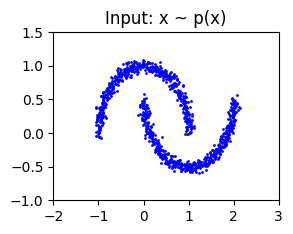

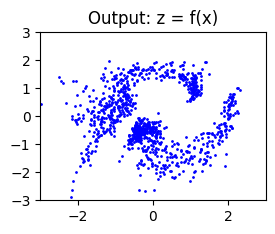

====> Test loss: -0.0504


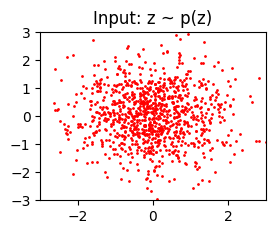

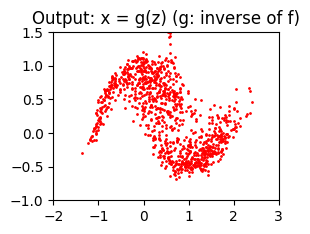

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.049102
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.049708
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.050859
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.051926
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.053337
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.053979
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.053665
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.054659
====> Epoch: 2 Average train loss: -0.0527


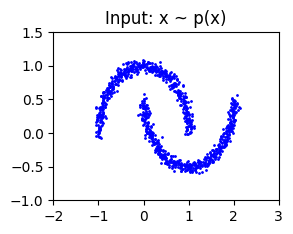

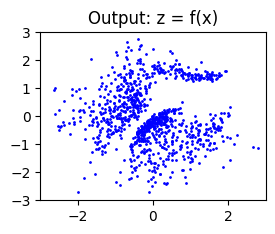

====> Test loss: -0.0561


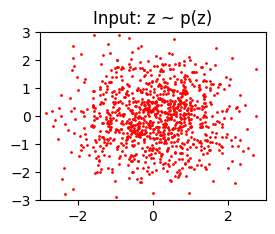

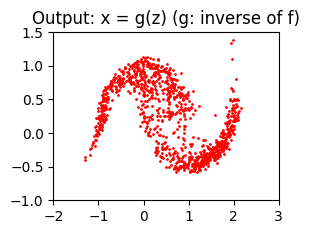

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.054387
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.055555
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.055764
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.054813
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.055287
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.055895
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.056661
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.057222
====> Epoch: 3 Average train loss: -0.0557


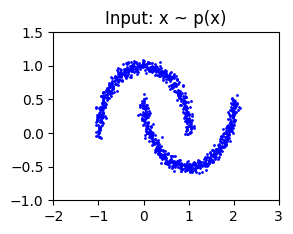

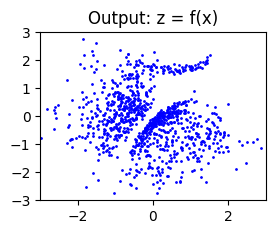

====> Test loss: -0.0576


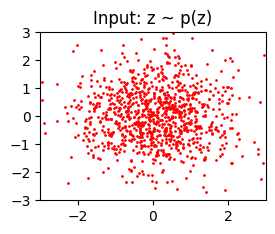

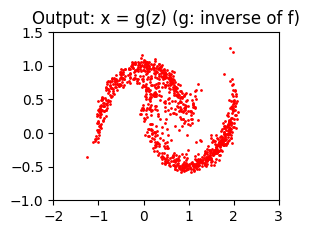

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.057064
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.056803
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.057407
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.057139
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.056547
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.057436
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.056751
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.056966
====> Epoch: 4 Average train loss: -0.0571


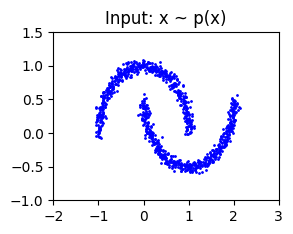

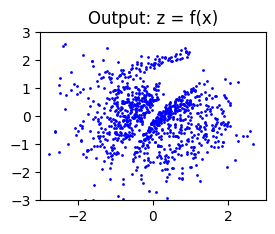

====> Test loss: -0.0589


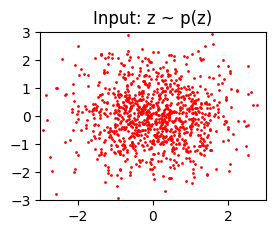

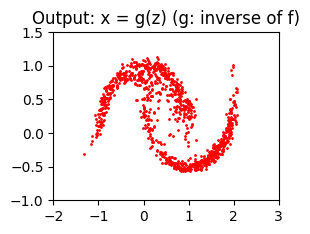

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.057053
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.057445
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.057413
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.057235
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.058164
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.058092
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.058241
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.058637
====> Epoch: 5 Average train loss: -0.0578


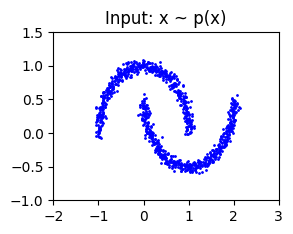

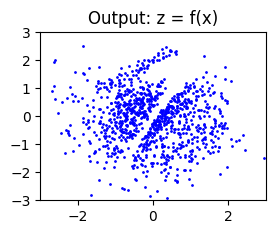

====> Test loss: -0.0594


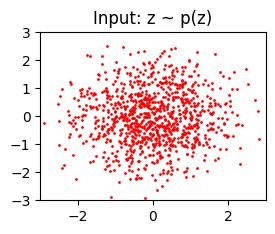

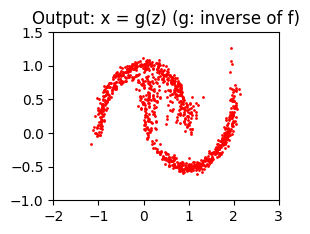

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.057664
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.056645
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.058142
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.057900
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.057940
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.058859
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.058515
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.058785
====> Epoch: 6 Average train loss: -0.0583


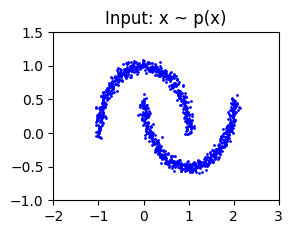

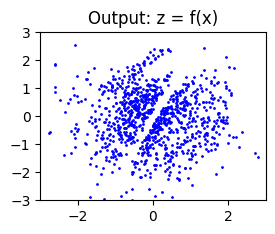

====> Test loss: -0.0597


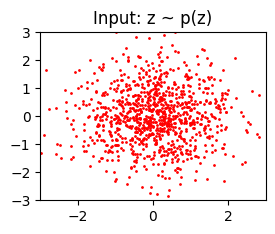

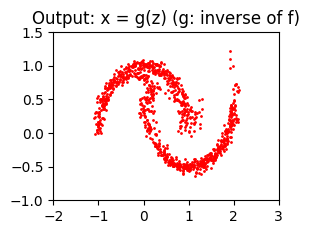

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.058652
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.058342
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.059262
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.057691
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.058200
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.058600
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.057255
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.056929
====> Epoch: 7 Average train loss: -0.0586


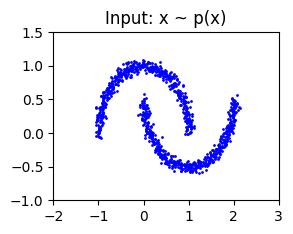

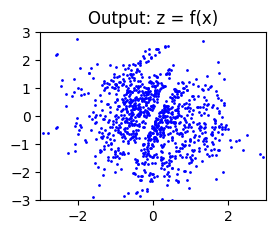

====> Test loss: -0.0598


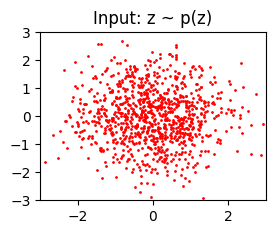

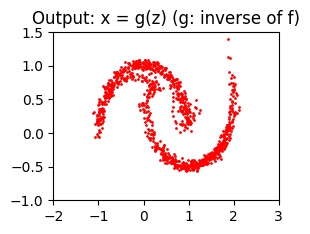

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.058800
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059154
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059068
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.058727
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059337
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.058514
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.058375
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059173
====> Epoch: 8 Average train loss: -0.0588


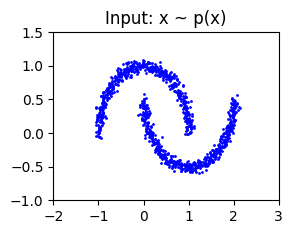

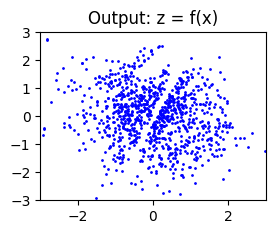

====> Test loss: -0.0601


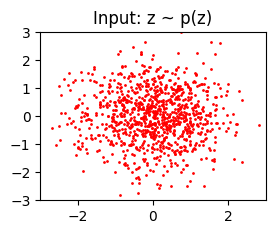

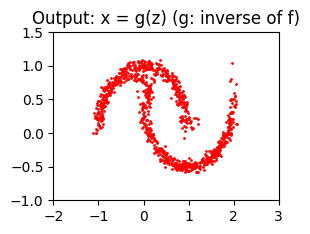

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.058435
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.059137
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.059197
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.058575
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.057922
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.058439
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.058417
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.058664
====> Epoch: 9 Average train loss: -0.0590


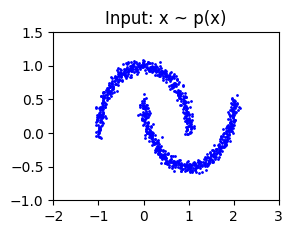

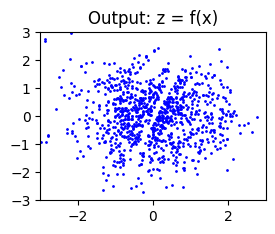

====> Test loss: -0.0603


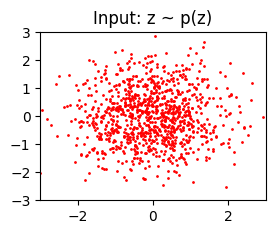

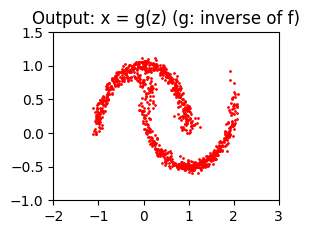

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.058510
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.058929
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059252
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.059063
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.058642
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059340
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.059335
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.060091
====> Epoch: 10 Average train loss: -0.0591


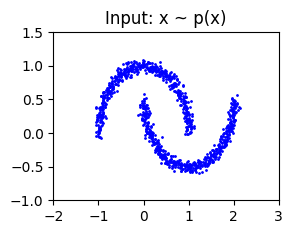

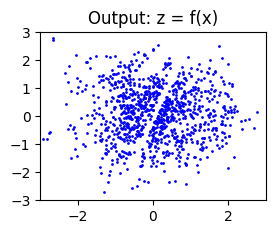

====> Test loss: -0.0603


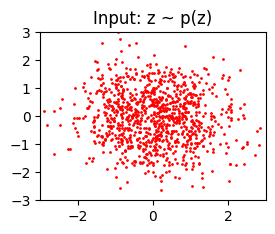

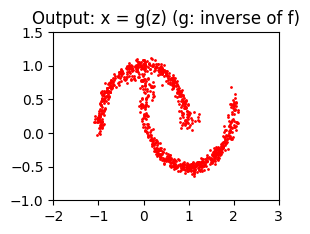

'61.65s'

<Figure size 640x480 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

 The main reason is that they use a smooth and invertible function to change the data distribution to a simpler one, like a standard Gaussian distribution. This function is built from easy transformations that might not be enough to capture the complex relationships between the different clusters in the data.

When we have many clusters, the data distribution is more complex, and the mapping function needs to be more flexible to fit it well. However, normalizing flows use simple transformations that might not be able to model these relationships, leading to poor performance.

Additionally, normalizing flows use the determinant of the Jacobian matrix, which is important for optimizing the function. With many clusters, the computation of the determinant can be difficult and may cause the gradients to vanish or explode. This makes it challenging for normalizing flows to learn complex data with many clusters.

## Denoising Diffusion Model

Recently Diffusion Models received a lot of attention. __Diffusion Models Beat GANs on Image Synthesis__ *(Dhariwal,Nichol)* : [arXiv:2105.05233](https://arxiv.org/pdf/2105.05233.pdf) shows significant improvement on image generation with a model claimed to be easier to train than GANs.


It is the key of the image generating process behind Latent Diffusion models such as Dall.e, Imagen or StableDiffusion.

We are going to implement a model inspired by the paper
__Denoising Diffusion Probabilistic Models__  *(Ho et al.)*: [arXiv:2006.11239](https://arxiv.org/pdf/2006.11239.pdf)


 Denoising diffusion probabilistic model  introduce noise into data and gradually learn to reverse this process for generating new samples. It involves two Markov chains, one that forwards data to noise, and another that reverses this process by converting the noise back to data. The forward chain is usually designed to transform any data distribution into a simpler prior distribution, such as a standard Gaussian distribution, while the reverse Markov chain is parametrized by a neural network and learns to reverse this process. To generate new data points, we first sample a random vector from the prior distribution, then applies ancestral sampling through the reverse Markov chain.


![Denoisingdiagram](illustrationDenoising.png)

$q$ and $p_{\theta}$ being the respective kernels of the two chains.


#### Forward Pass ####

For our purpose we are going to use a Gaussian Noise. The forward Kernel will have the following shape :

$$q(x_t| x_{t-1}) = \mathcal{N}(x_t;\sqrt{1- \beta_t} x_{t-1},\beta_t I )$$

with $\mathcal{N}(x;\mu,\sigma I )$ a conditional gaussian :
$$ y \sim \mathcal{N}(x;\mu,\sigma I ) \equiv y|x \sim  \mathcal{N}(\mu,\sigma I )$$

**Q20: What does $\beta_t$ represent in the formula ?**

In the denoising diffusion model, $\beta_t$ is a parameter at each step $t$. It shows the amount of noise added to the data at each step.

The noise schedule is a list of $\beta_t$ values that balance the strength of the noise and the amount of cleaning. As the diffusion process goes on, the noise schedule usually starts with smaller values, meaning less noise, and slowly grows to bigger values, meaning more noise is added. This lets the model slowly change the data distribution into the noise distribution over many steps.

In the forward kernel formula, $\beta_t$ is used to change the size of the Gaussian noise, and it also scales.

In our example the sequence $\beta_t$ will be chosen linearly wrt $t$.

In [ ]:
def linear_beta_schedule(timesteps=1000,start=1e-4, end=1e-2):
    """ Return the values of beta for all timesteps"""
    return torch.linspace(start, end, timesteps)

Following the paper, we introduce $\alpha_t := 1-\beta_t$ and $\overline{\alpha_t} = \prod_{t=1}^{T} \alpha_t$ we can sample forward directly at timestep t from the original image :
$$q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t=1}^{T}q(\mathbf{x}_t|\mathbf{x}_{t-1})$$
$$ q(\mathbf{x}_t| \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\overline{\alpha_t}} \mathbf{x}_0, (1-\overline{\alpha_t})I)$$

**Q21:  Implement the forward pass using $\overline{\alpha_t}$ (Hint : you may need to precalculate the $\overline{\alpha_t}$ from $\beta_t$)**

In [ ]:
def forward_close_form(x_0, t):
    """Take an input image and a timestep, sample the forward markov chain until the timestep is attained."""
    noise = torch.randn_like(x_0)

    # If t=0, there is nothing to do
    if t==0:
      return x_t, noise

    # Here, we set the beta_schedule
    beta_schedule = linear_beta_schedule()

    # Compute the alpha_t values
    alpha_t = 1 - beta_schedule[:t]

    # Compute the cumulative product of alpha_t values
    alpha_cum_product = torch.cumprod(alpha_t, dim=0)

    # Calculate the x_t value
    x_t = torch.sqrt(alpha_cum_product[-1]) * x_0 + torch.sqrt(1 - alpha_cum_product[-1]) * noise

    return x_t, noise

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs,drop_last=True)

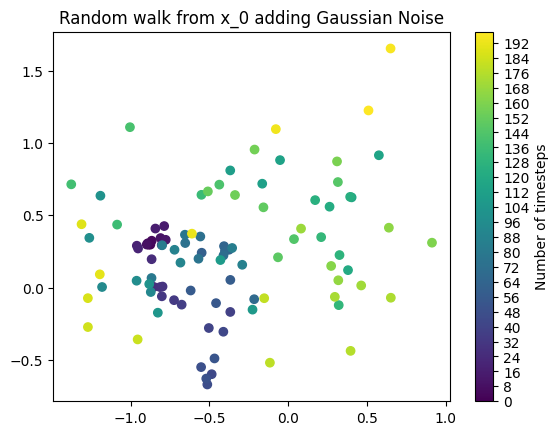

In [ ]:
# Simulate forward diffusion
from matplotlib import ticker

T=200
image = next(iter(train_loader))[0]
plt.scatter
num_images = 100
images = np.zeros((num_images,2))
images[0]=image
stepsize = int(T/num_images)
color = np.arange(num_images)

for idx in range(1, T,stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    #print(image.shape,type(image),stepsize,idx,t)
    image, _ = forward_close_form(image, t)
    images[int(idx/stepsize)] = image

plt.scatter(images[:,0],images[:,1],c=color*stepsize,)
plt.title("Random walk from x_0 adding Gaussian Noise")
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=30)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label("Number of timesteps")
plt.show()

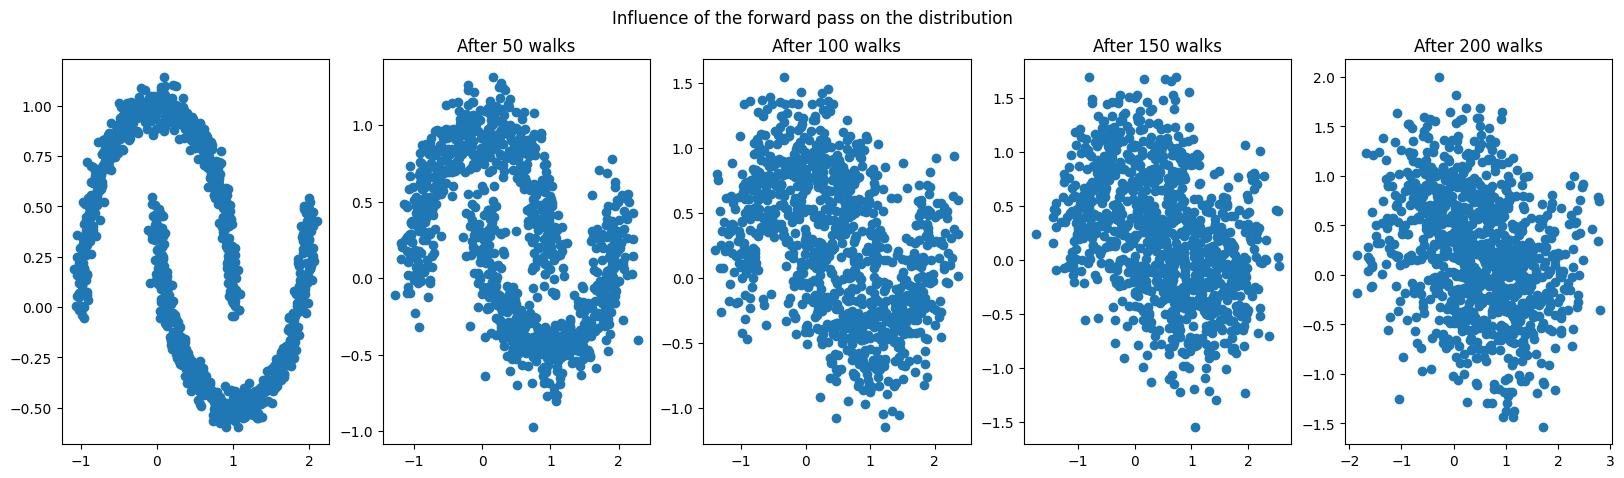

In [ ]:
# Effect on the distribution
torch_test_data = torch.Tensor(test_data)
def apply_on_dataset(dataset,t):
    dataset_t = torch.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        point = dataset[i]
        point_t,_ = forward_close_form(point, t)
        dataset_t[i] = point_t
    return dataset_t

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].scatter(torch_test_data[:,0],torch_test_data[:,1])
for i in range(1,5):
    t = torch.Tensor([i*50]).type(torch.int64)
    dataset_t = apply_on_dataset(torch_test_data,t)
    axes[i].scatter(dataset_t[:,0],dataset_t[:,1])
    axes[i].set_title(f"After {t.detach().item()} walks")
fig.suptitle("Influence of the forward pass on the distribution")
plt.show()



#### Backward Process

Hypothetically, We would like  to train the reverse kernel $p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$, with parameters $\theta$ parametrized by a neural network

$$
p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)
$$

with $p(\mathbf{x}_T)$ a Gaussian prior, $p(\mathbf{x}_T) \sim \mathcal{N}(0,I)$ . We would use $p(\mathbf{x}_T)$ to sample new data points for generation.

#### Variational Lower Bound

In the paper, they used the knowledge of the forward pass and design a  Gaussian  reverse kernel

$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$

with $\mu_{\theta}$ and $\Sigma_{\theta}$  parametrized by a neural network

We can write the previous forward kernel
$$
\begin{aligned}
q\left(\mathbf{x}_t \mid \mathbf{x}_0\right) & =\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right) \\
& =\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\epsilon \sqrt{1-\bar{\alpha}_t}
\end{aligned}
$$
with $ \epsilon \sim \mathcal{N}(0, \mathbf{I})$

The natural loss would be to optimize under the variational lower bound $L_t$ such that :
$$
\begin{aligned}
L_{\mathrm{vlb}} & :=L_0+L_1+\ldots+L_{T-1}+L_T \\
L_0 & :=-\log p_\theta\left(x_0 \mid x_1\right) \\
L_{t-1} & :=D_{K L}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right) \\
L_T & :=D_{K L}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)
\end{aligned}
$$

You can show ( and you are welcome to do so) that an alternative loss can be used that only take one parametrized estimator $\epsilon_{\theta}$
$$
L_{\text {simple }}(\theta):=\mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}}\left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\right]
$$

**Q.23 Implement the Simplified loss given a model $\epsilon_{\theta}$**

In [ ]:
def get_loss(model, x_0, t):
    """Return the Loss.

    Args:
        model (nn.Module): epsilon_theta
        x_0 (torch.Tensor): Original Image
        t (torch.Tensor): Integer describing time
    """
    x_noisy, noise = forward_close_form(x_0, t, device)
    #
    # TO COMPLETE
    #
    return 0

From the paper [arxiv:1706.03762](https://arxiv.org/pdf/1706.03762.pdf) we can use Sinusoidal Position Embeddings to help the model represent time position  of the noised input $(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon})$ on the reverse markov chain given $t$.

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

**Q.24 Implement and train $\epsilon_{\theta}(\mathbf{x},t)$ that take as entry a transformed vector $\mathbf{x}$ and  $t$ a number of time $\mathbf{x}$ passed through the forward process  and return  a direct estimate of  the noise $\epsilon$**

In [ ]:
class Simple_Reverse_Kernel(torch.nn.Module): # To
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 2)
        self.time_embedding = SinusoidalPositionEmbeddings(32)
        self.time_mlp = torch.nn.Linear(32,2)
        self.merge_mlp = torch.nn.Linear(4,2)

    def forward(self, x,t):
        x = F.relu(self.fc1(x))
        t = F.relu(self.time_mlp(self.time_embedding(t).reshape(-1,32)))
        return self.merge_mlp(torch.cat((x,t ),dim=1))


#### Training

**Q.25 Test this  training procedure for multiple architectures and analyse your results.**

In [ ]:
def train(model,optimizer,n_epochs, data):
    error = []
    for epoch in range(n_epochs):
      for step, batch in enumerate(data):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        loss = get_loss(model, batch, t)
        loss.backward()
        optimizer.step()
      print(f"Epoch {epoch} | Loss: {loss.item()} ")
      error.append(loss.item())
    return error

In [ ]:
model = Simple_Reverse_Kernel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
error = train(model,optimizer,100,train_loader)

TypeError: ignored

> (Write your answer here)

#### Reconstruction of outputs

Given the noise obtained by the model $\boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)$, you can sample $\mu_{\theta}(\mathbf{x}_t,t)$ in order to get a denoised sample point.
$$
\mu_{\theta}(\mathbf{x}_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)
$$

**Q.26 Build the sampling function that allows you from inputs $\mathbf{x}_t$ and $t$ to obtain $\mu_{\theta}(\mathbf{x}_t,t)$**

In [ ]:
def sampling_model(x,t):
    #
    # TO COMPLETE
    #
    return mu_theta

In [ ]:
# Effect on the distribution
noise_dataset = torch.empty(1000,2).uniform_()
def backward_on_dataset(dataset,t):
    dataset_t = torch.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        point = dataset[i]
        noise_t= model(point.reshape(-1,2), t.unsqueeze(-1).float())
        point_t = sampling_model(point.reshape(-1,2),t)
        dataset_t[i] = point_t
    return dataset_t

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].scatter(noise_dataset[:,0],noise_dataset[:,1])
for i in range(1,5):
    t = torch.Tensor([i*50]).long()
    dataset_t = backward_on_dataset(noise_dataset,t)
    axes[i].scatter(dataset_t.detach().numpy()[:,0],dataset_t.detach().numpy()[:,1])
    axes[i].set_title(f"After {t.detach().item()} walks")
fig.suptitle("Influence of the backward pass on a test dataset")
plt.show()

Survey on Diffusion Models : https://arxiv.org/pdf/2209.00796.pdf

### Conclusion

**Q.27: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Normalizing flows and Denoising Models ?**

> (Write your answer here)